# Preparing input data

In [27]:
import sys, os
sys.path.append(os.path.dirname(os.getcwd()))

from signal_utils import *

import numpy as np
from pathlib import Path

# Parametri
N = 512
n = np.arange(N)
perc = 0.15
Fmax = 0.5 * (1 - perc)

M = 2
Fstart = 0.01
Fstop = Fmax - 0.01
F = np.linspace(Fstart, Fstop - 0.01, M)   # 64 frekvencije

OUTDIR = Path(r"../data/input/")
OUTDIR.mkdir(parents=True, exist_ok=True)

np.savetxt(OUTDIR / "N_000.txt", [M], fmt="%d")

for k, f in enumerate(F):
    # signal
    xi = (1.0 - 1.0*1e-15) * np.cos(2*np.pi*f*n)
    xq = (1.0 - 1.0*1e-15) * np.sin(2*np.pi*f*n)

    # ime fajla: index + frekvencija na 3 decimale
    # ftag = f"{f:.3f}"          # npr. '0.123'
    ftag = f"{f:.3f}".replace('.', 'p')   # '0p123'

    fi = OUTDIR / f"xinI_{k:03d}_f{ftag}.txt"
    fq = OUTDIR / f"xinQ_{k:03d}_f{ftag}.txt"

    # upis – real po liniji, kako TB već čita
    np.savetxt(fi, xi, fmt="%.15f")
    np.savetxt(fq, xq, fmt="%.15f")

print("Gotovo: generisani su svi ulazni fajlovi.")


Gotovo: generisani su svi ulazni fajlovi.


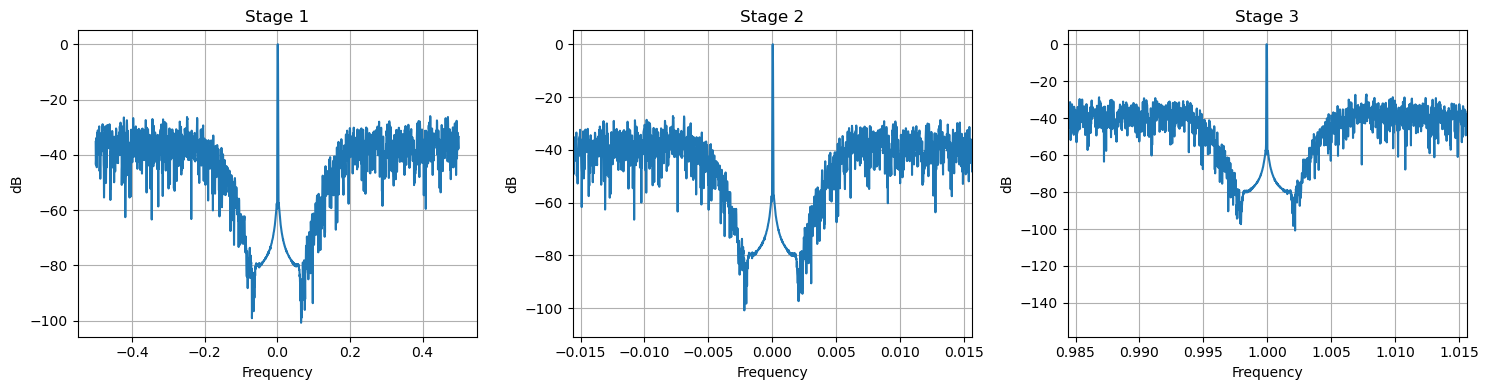

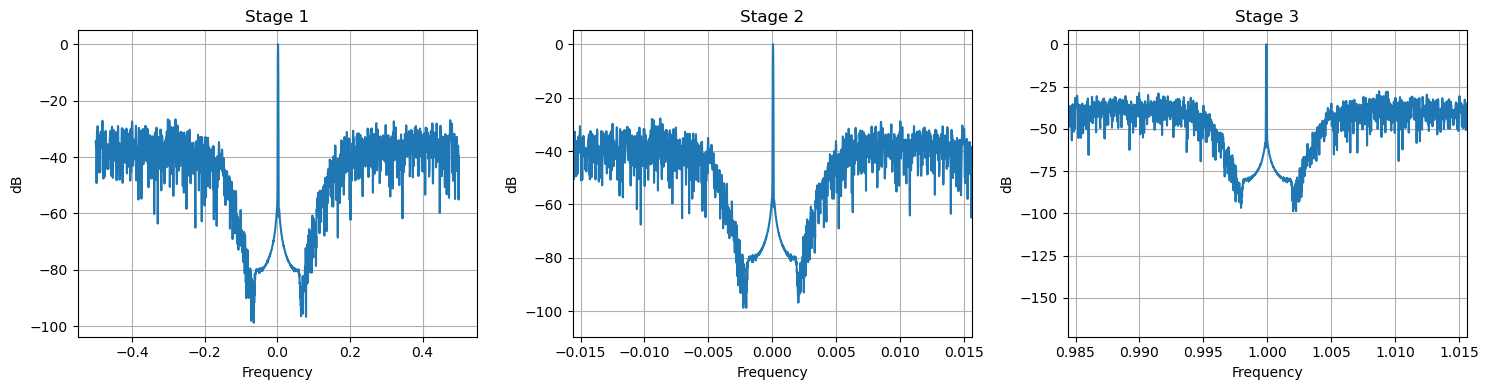

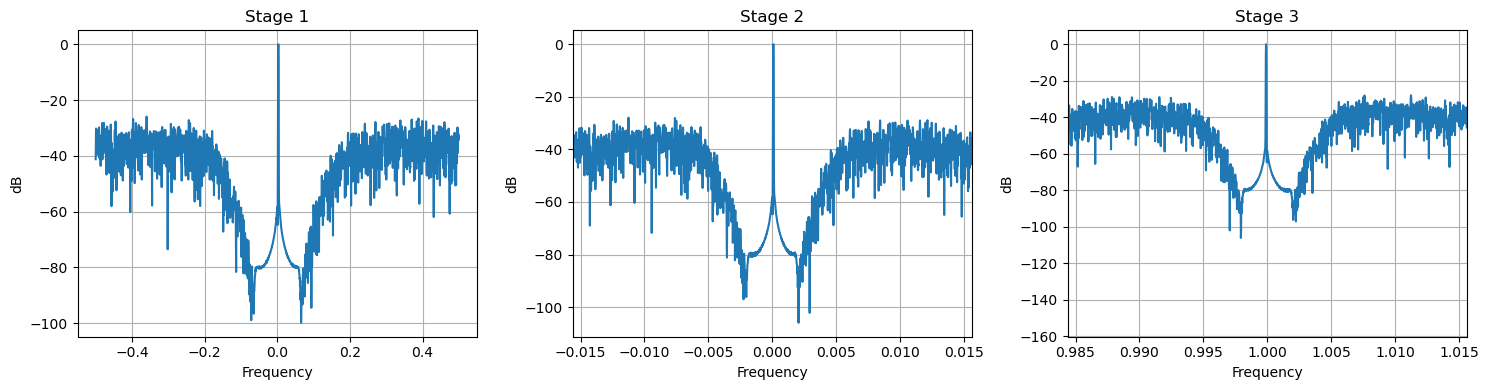

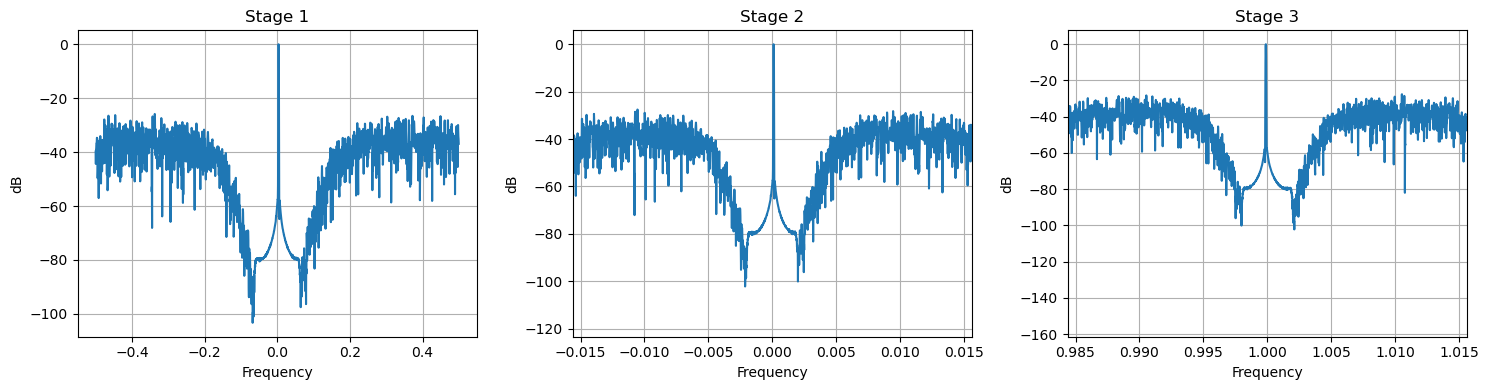

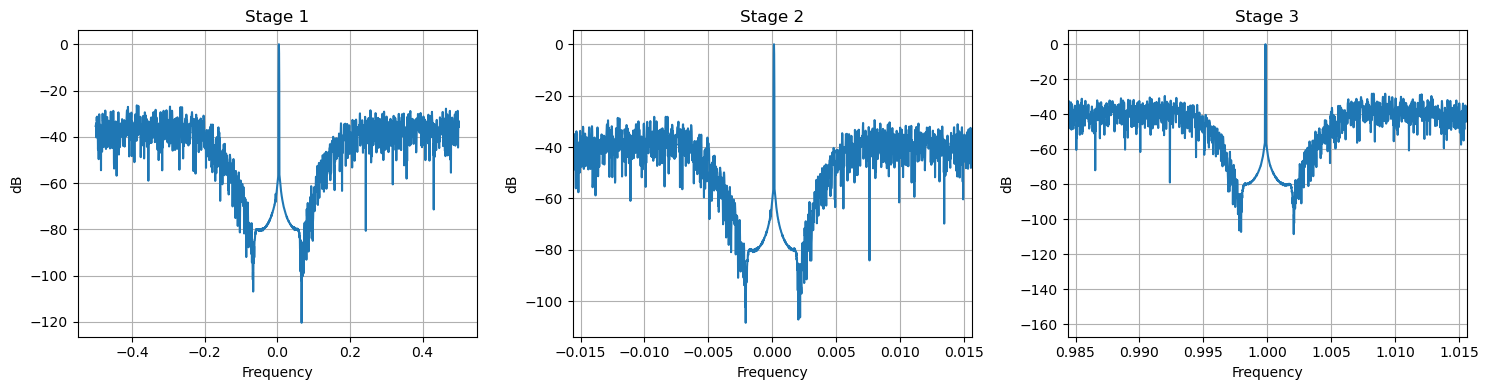

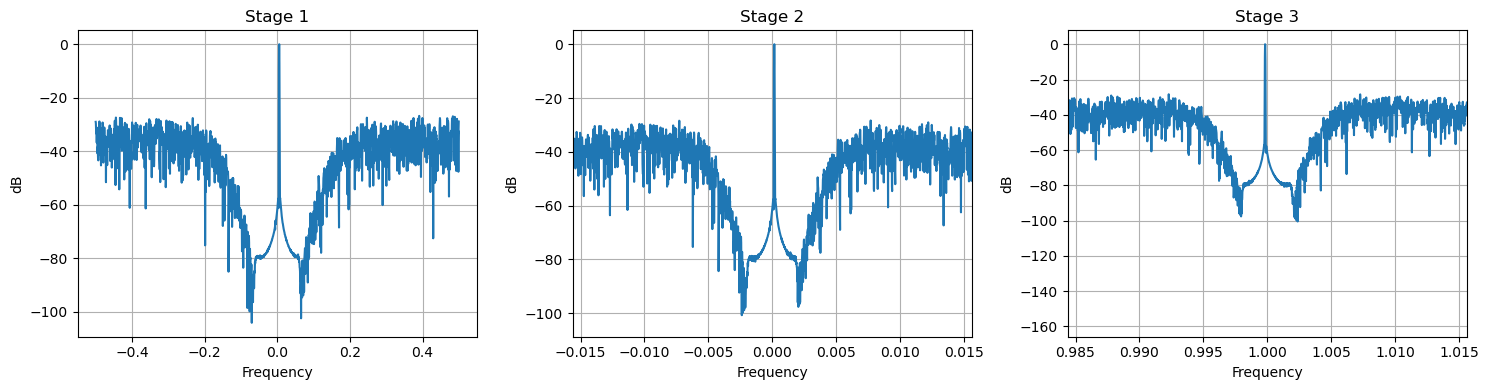

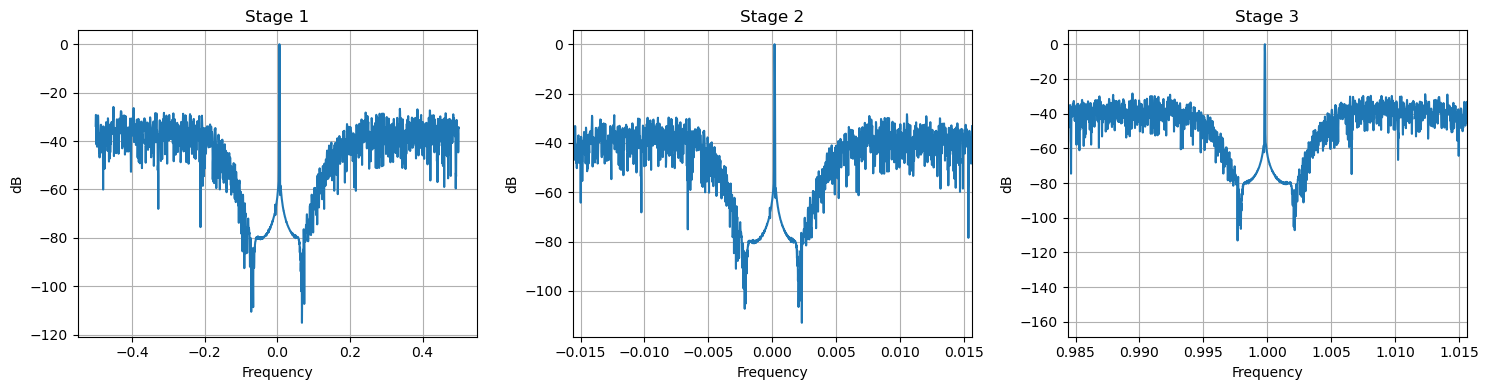

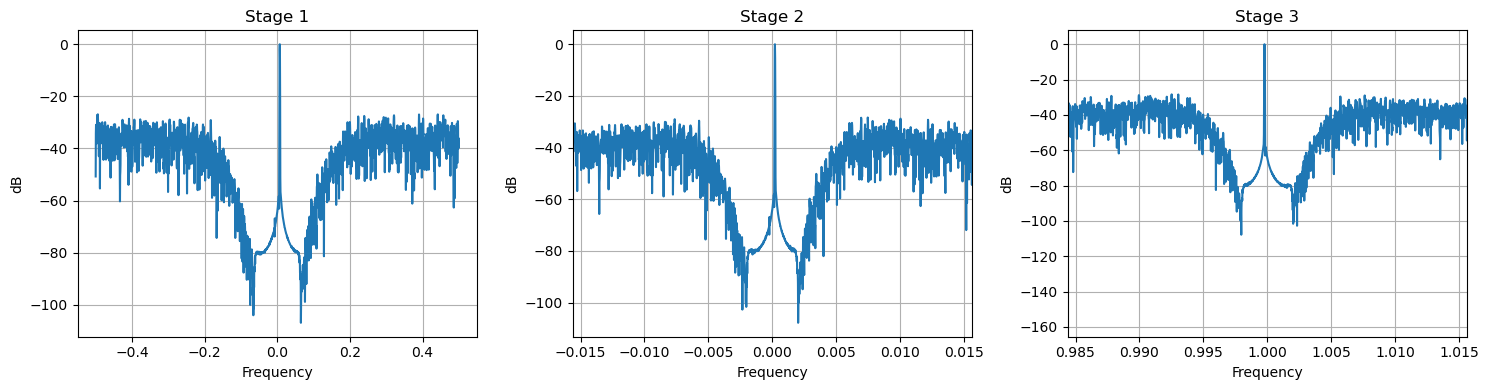

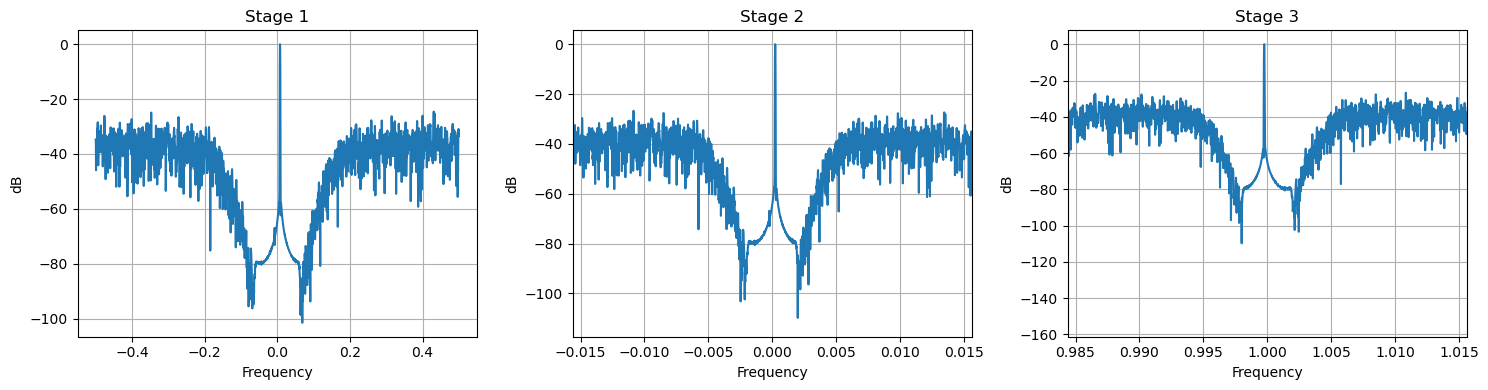

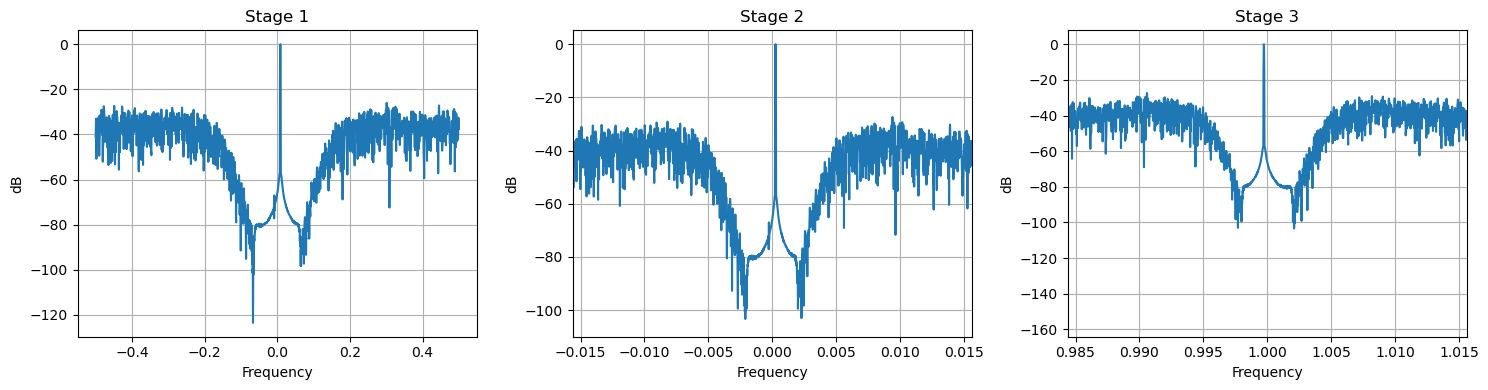

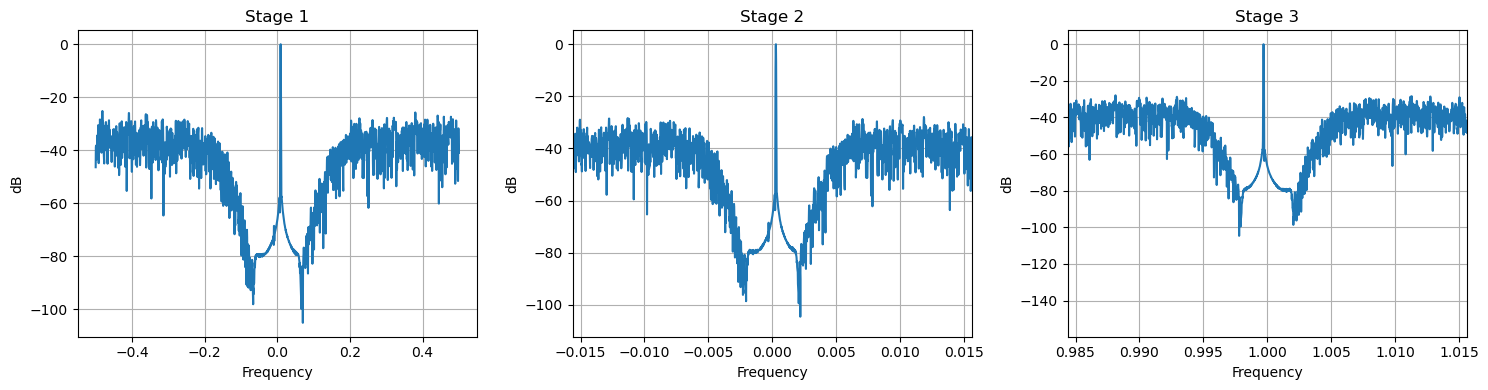

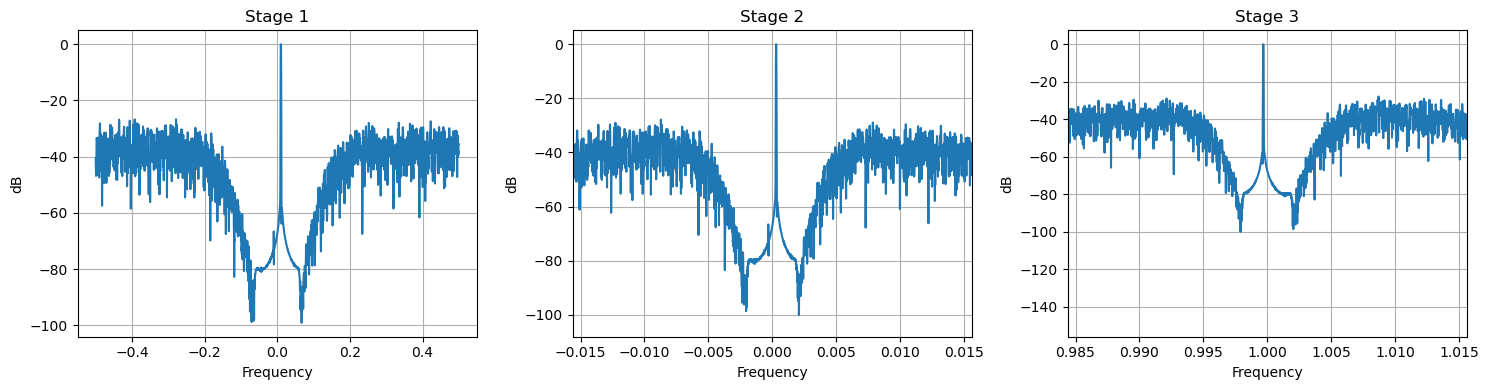

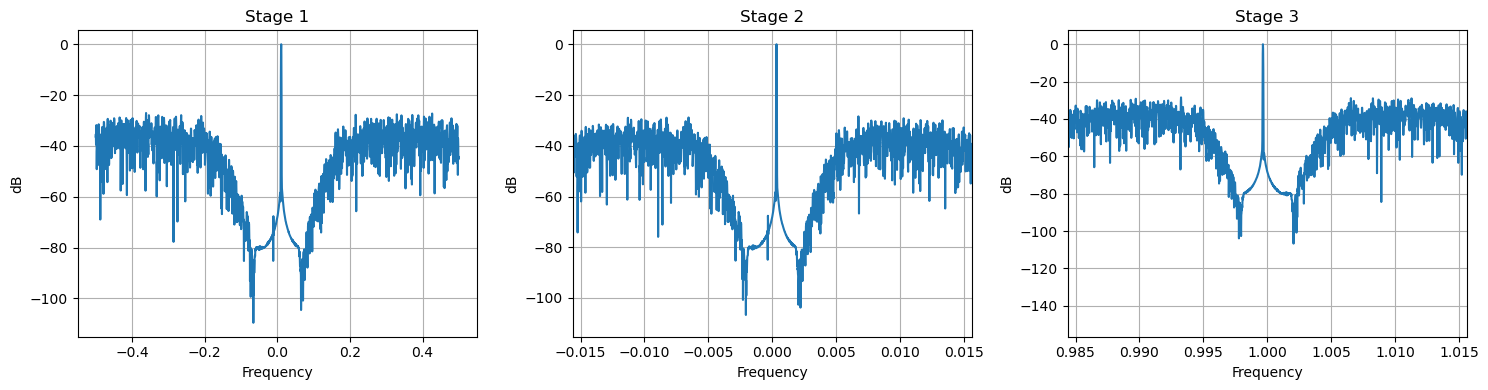

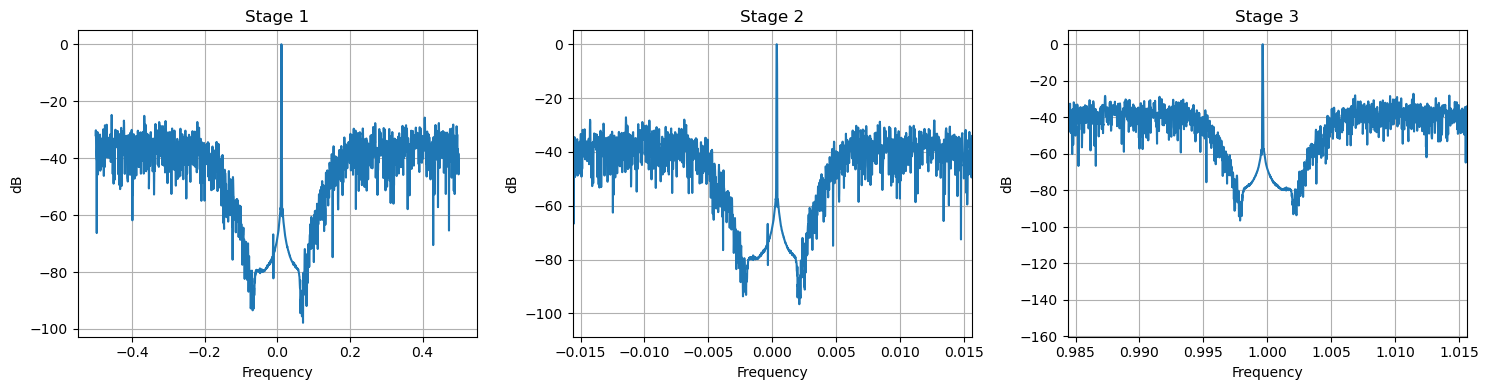

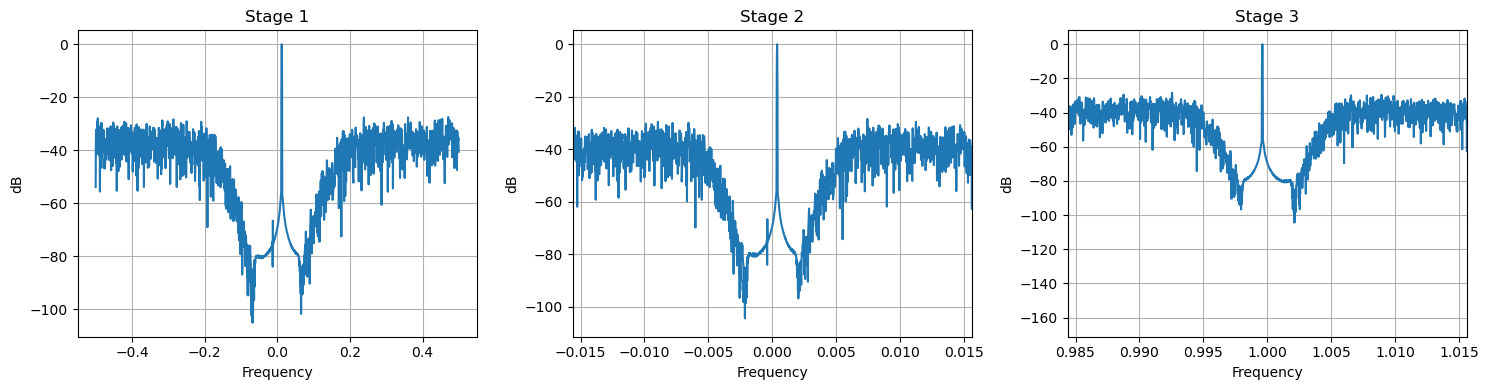

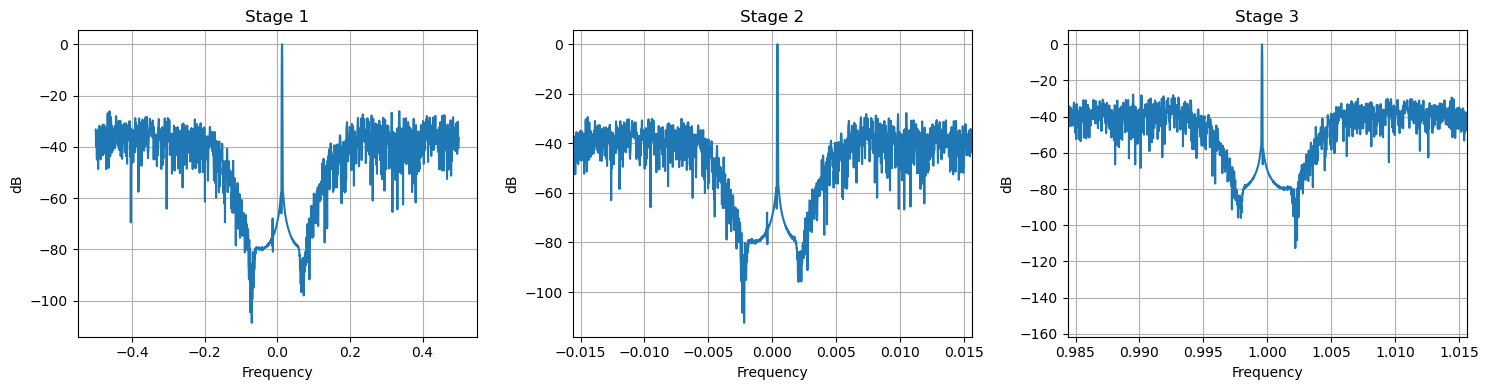

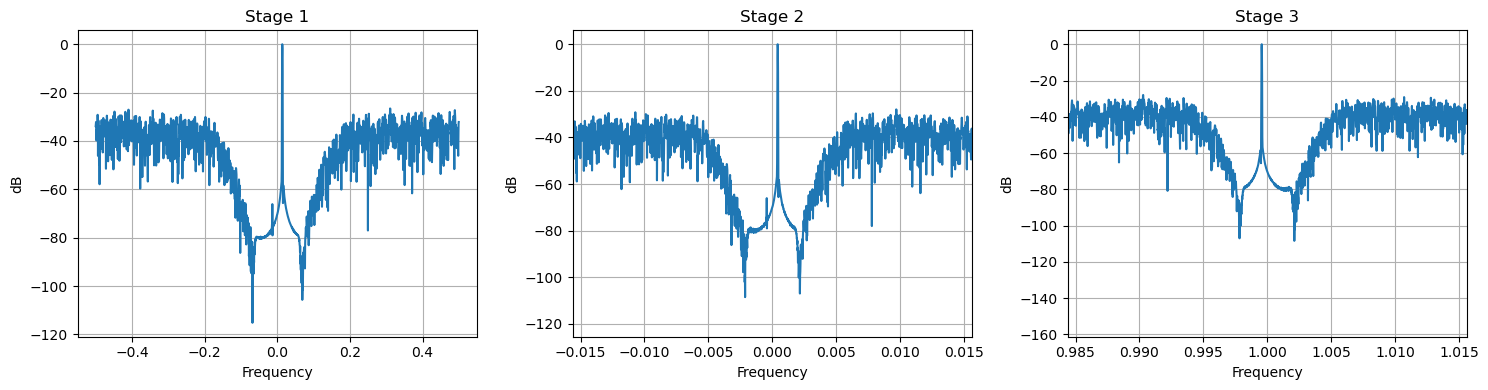

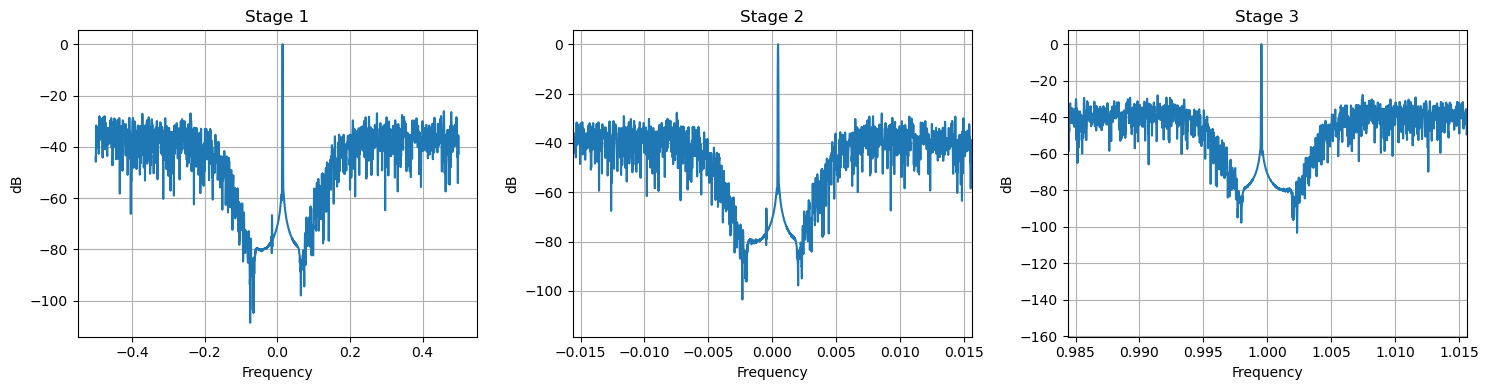

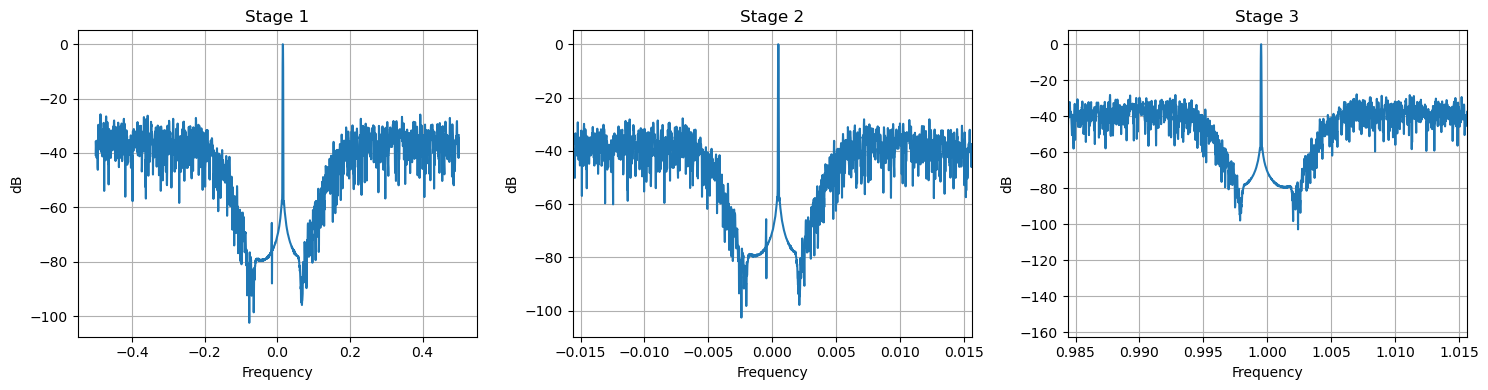

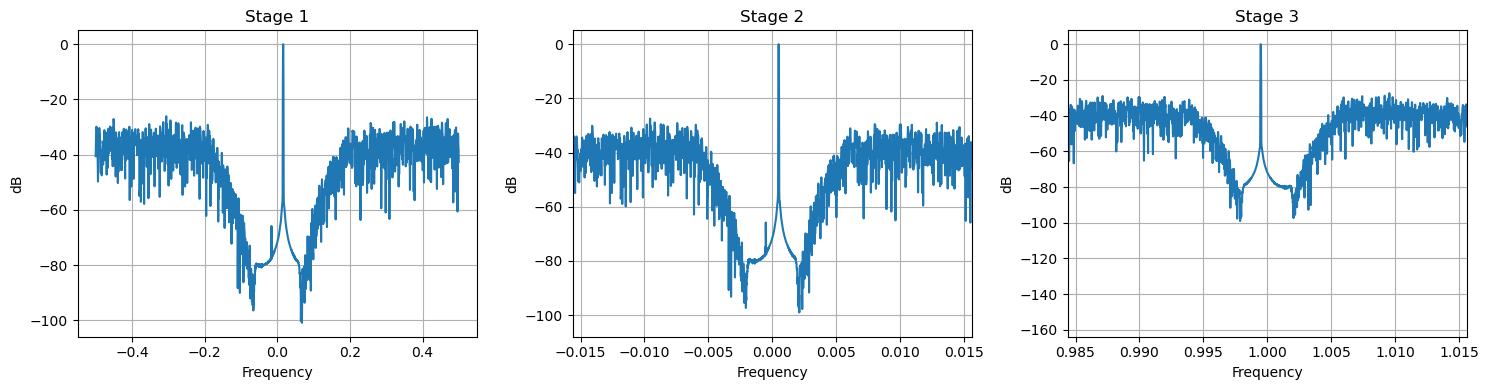

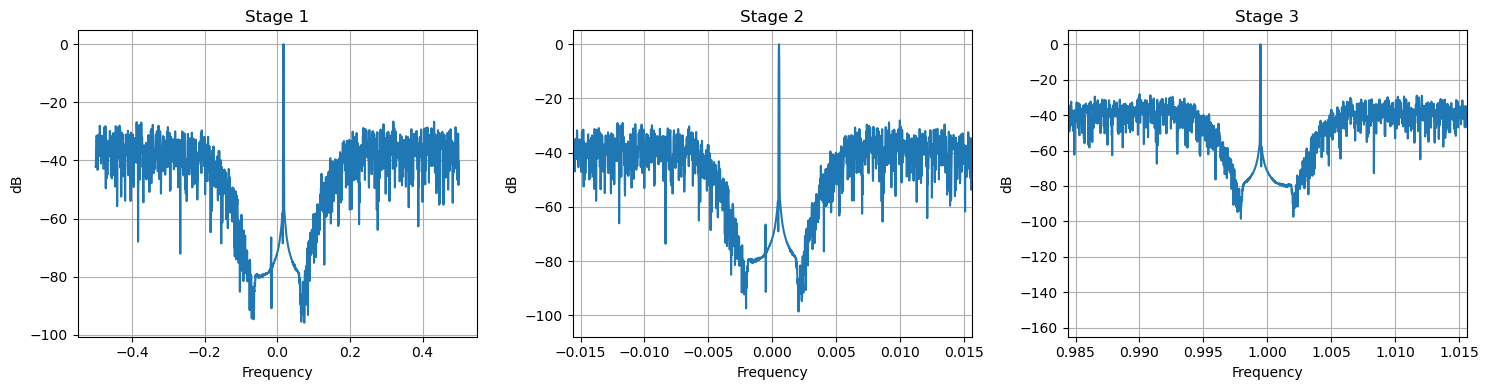

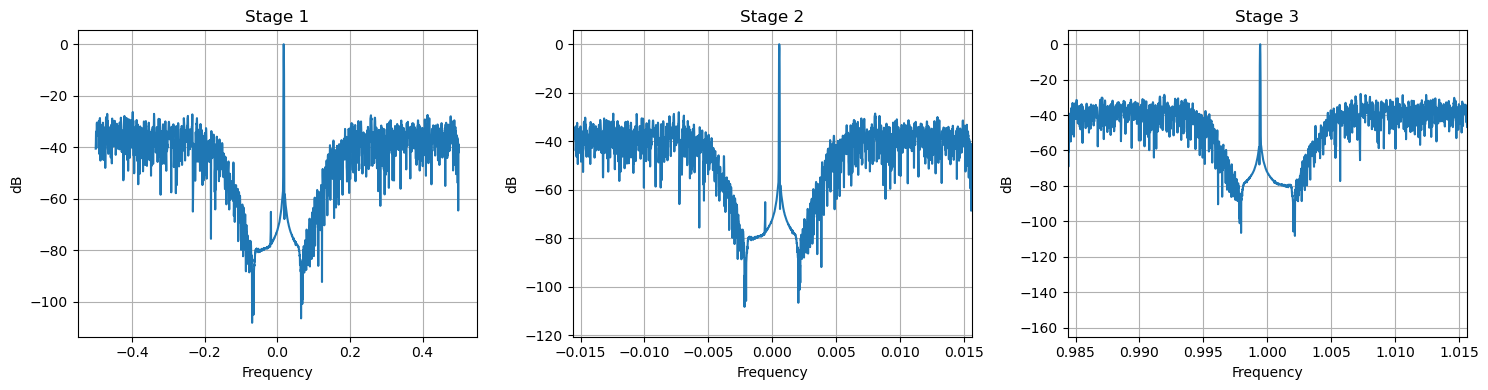

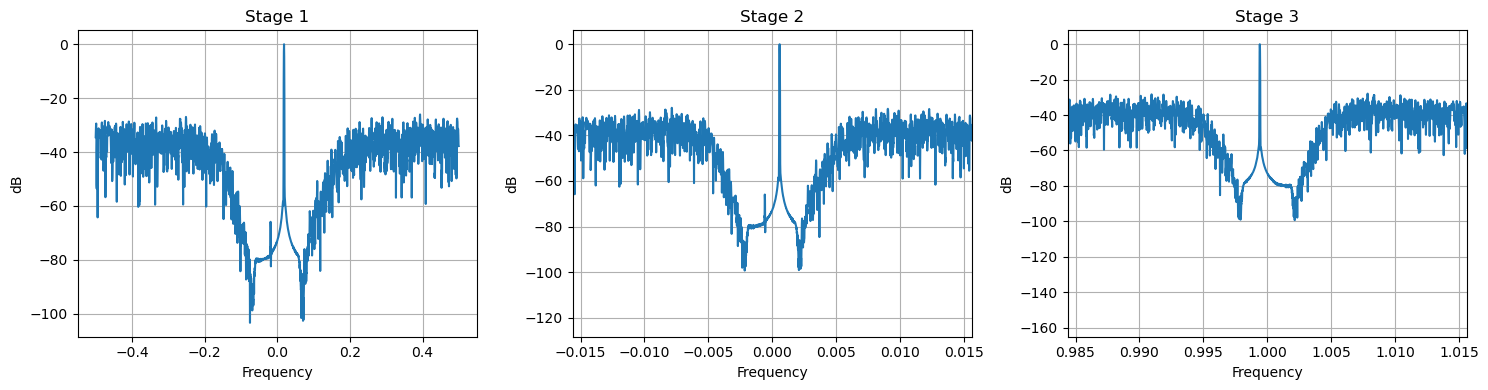

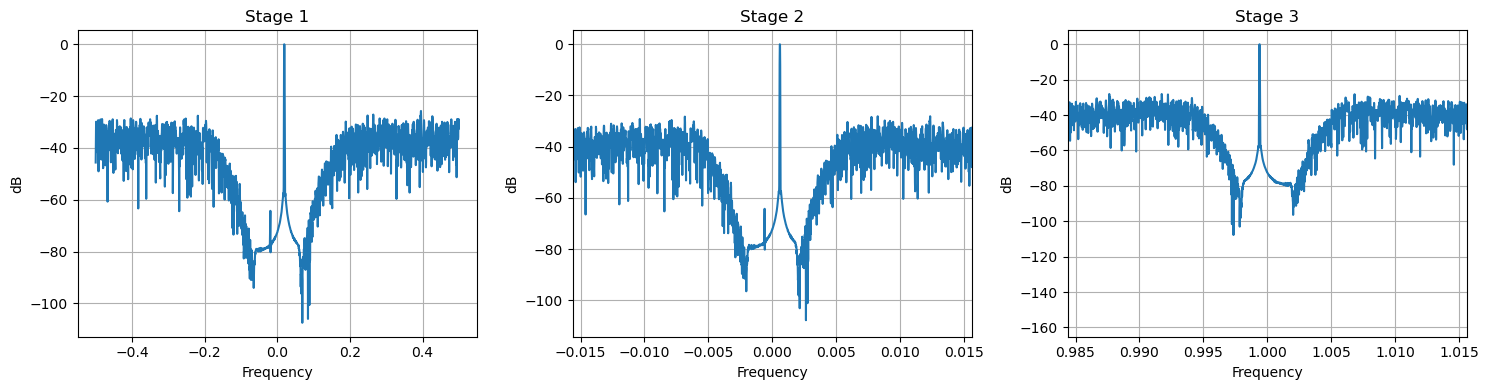

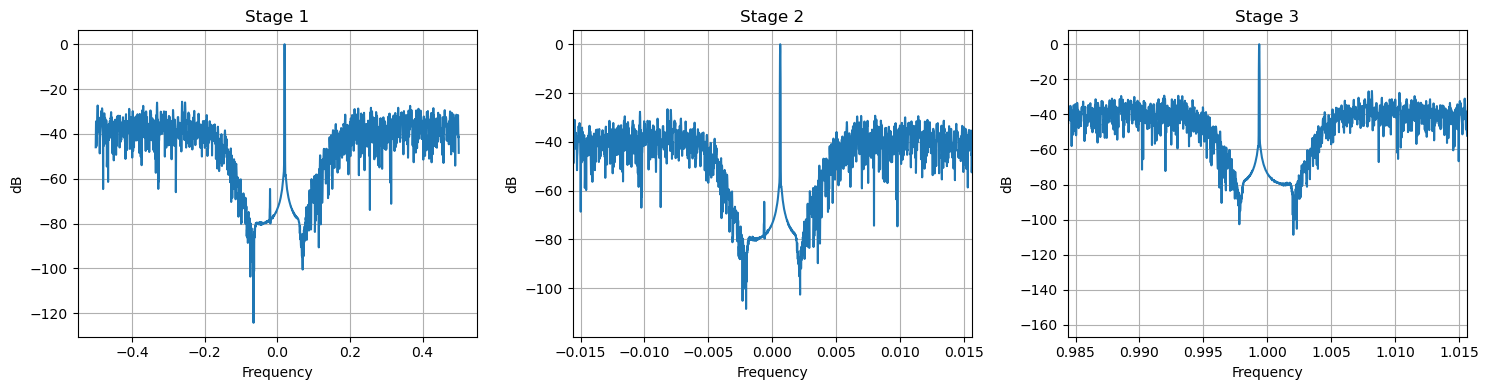

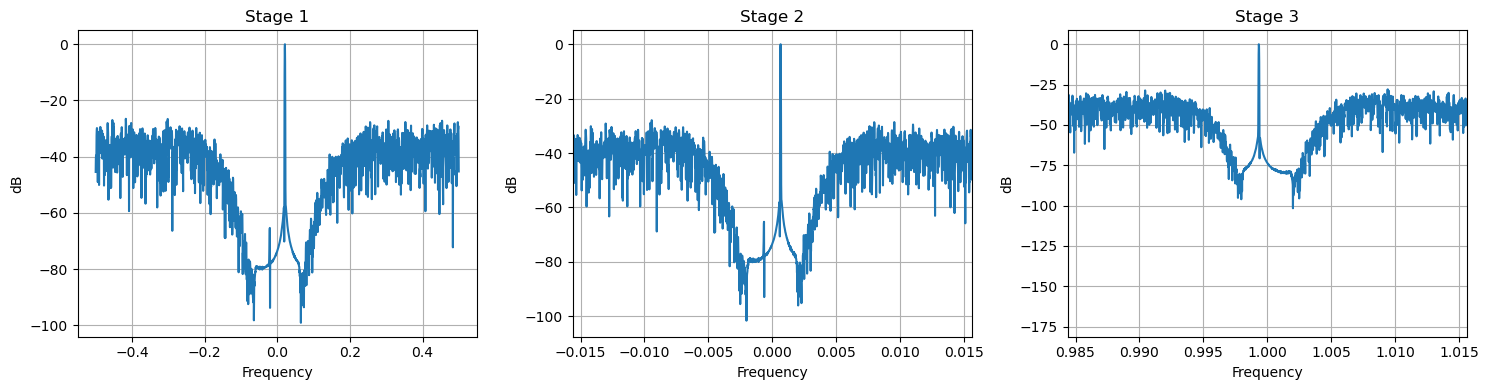

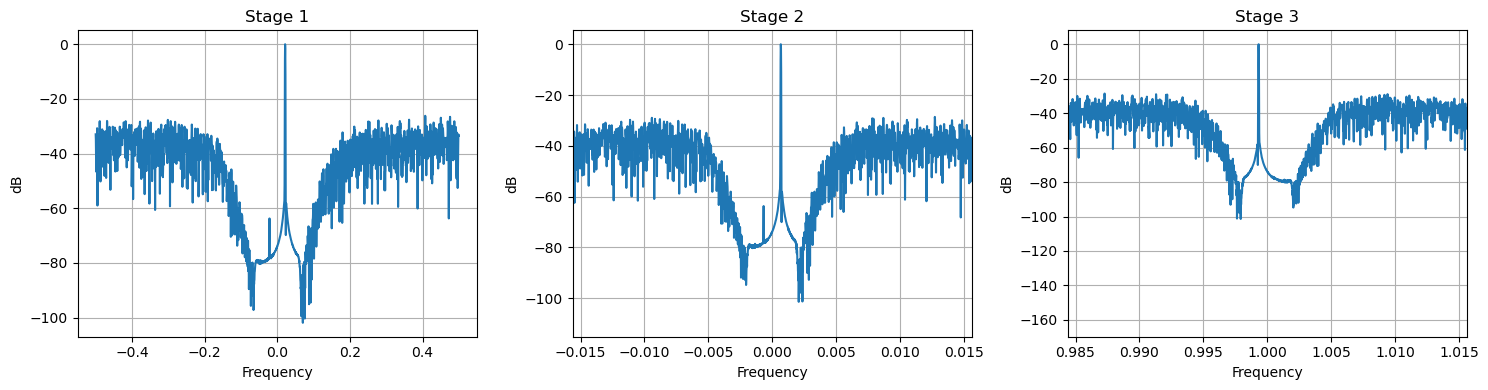

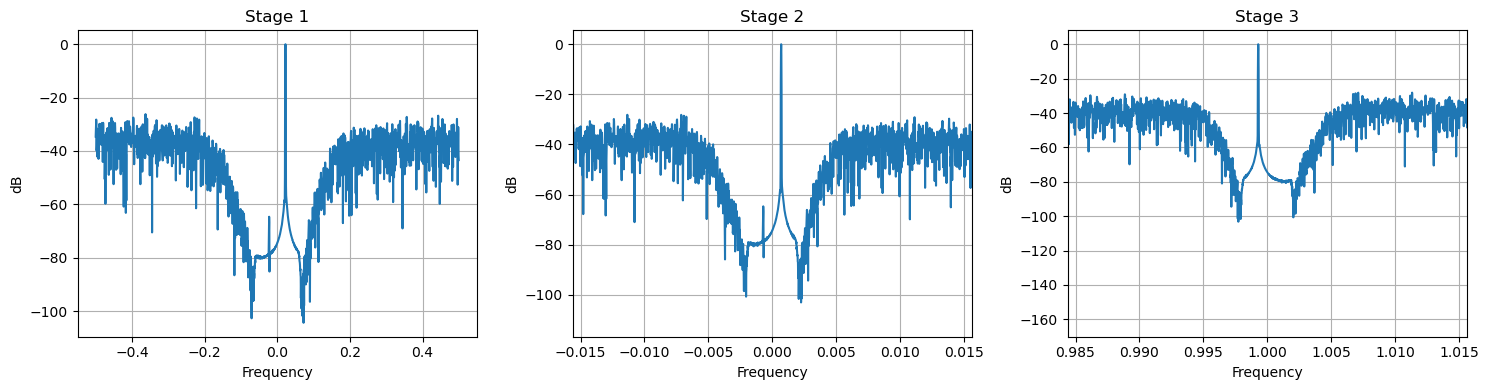

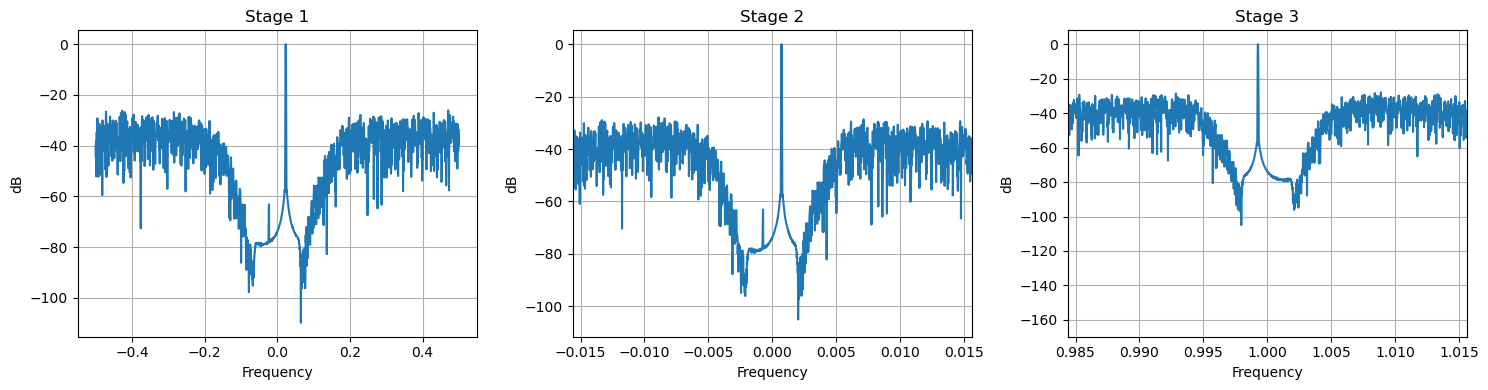

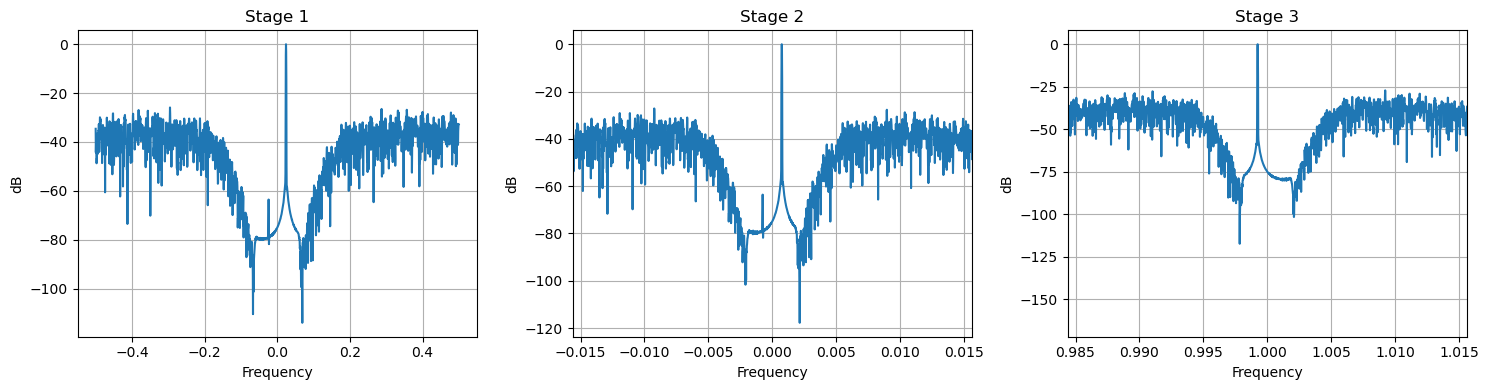

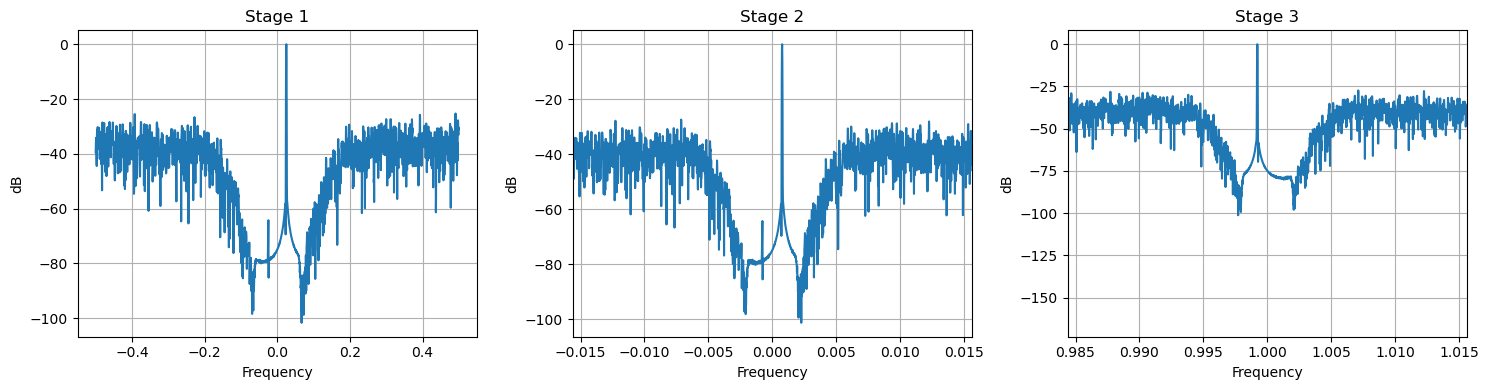

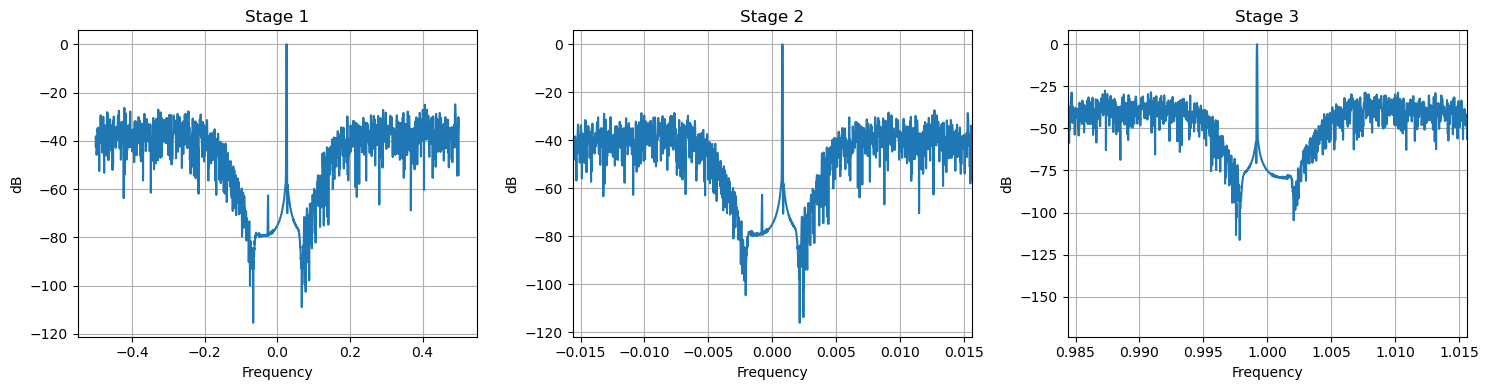

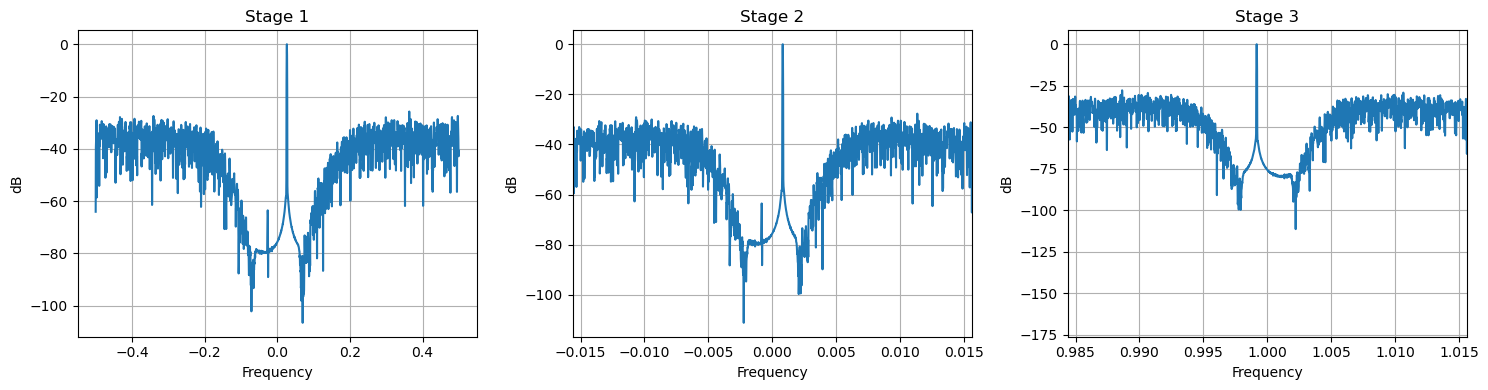

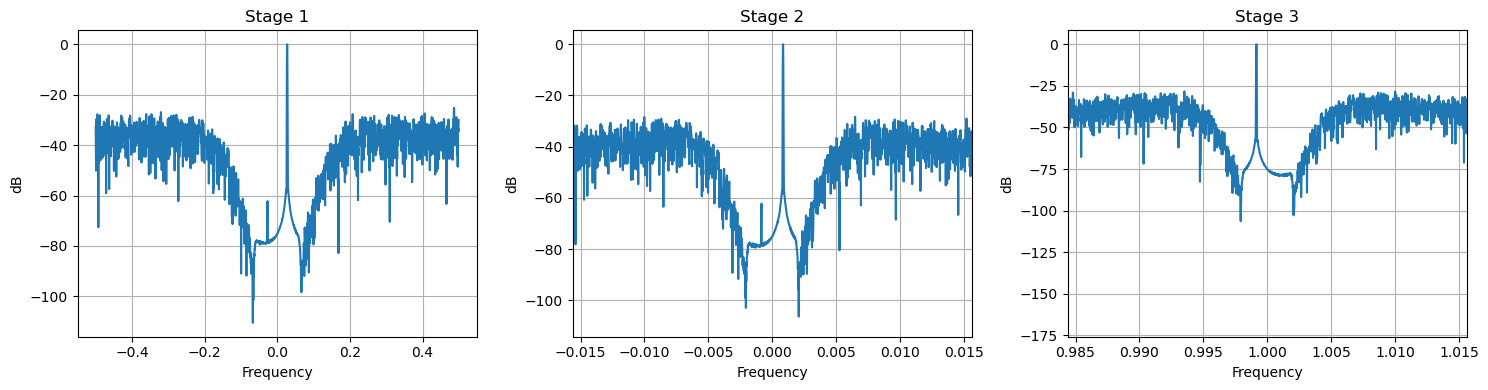

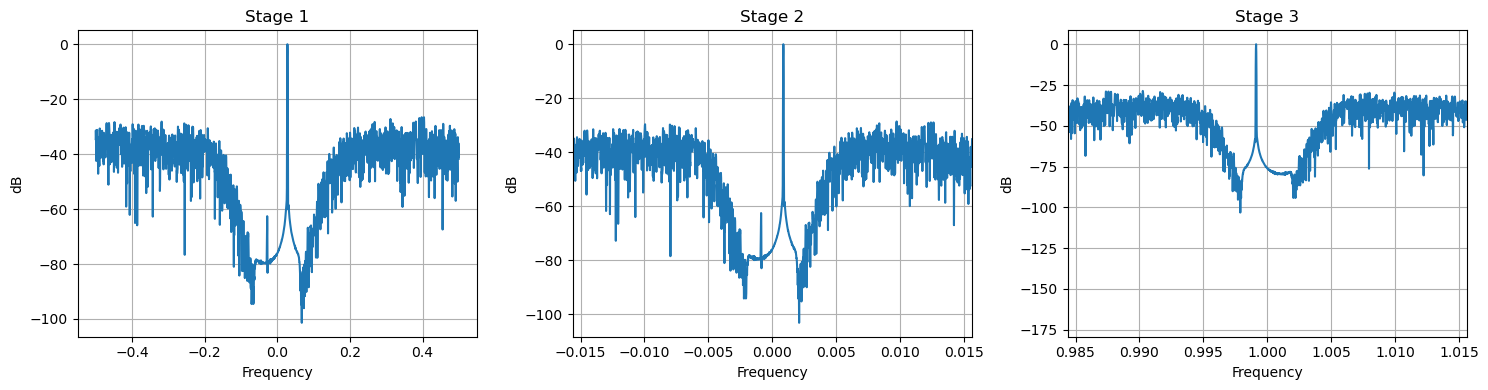

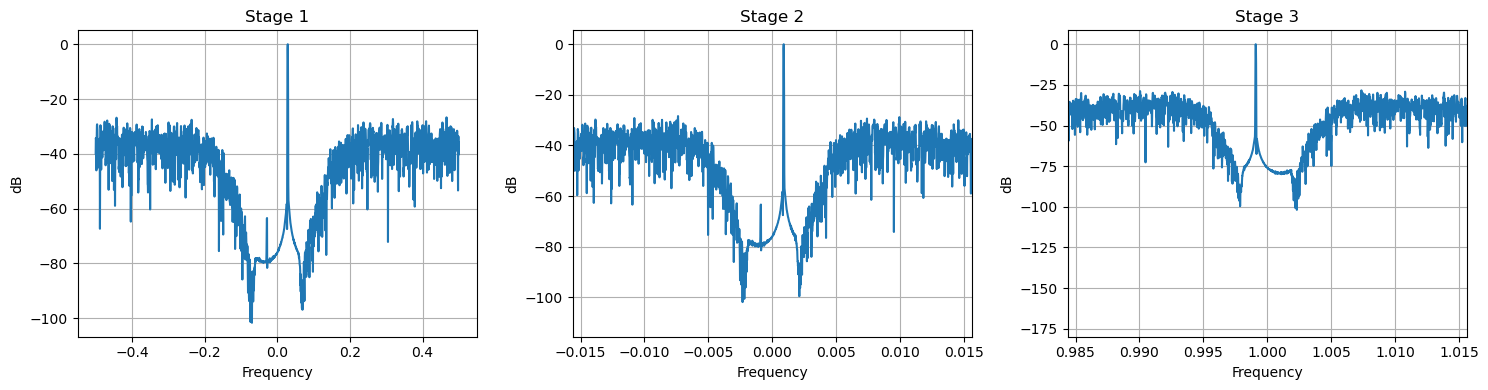

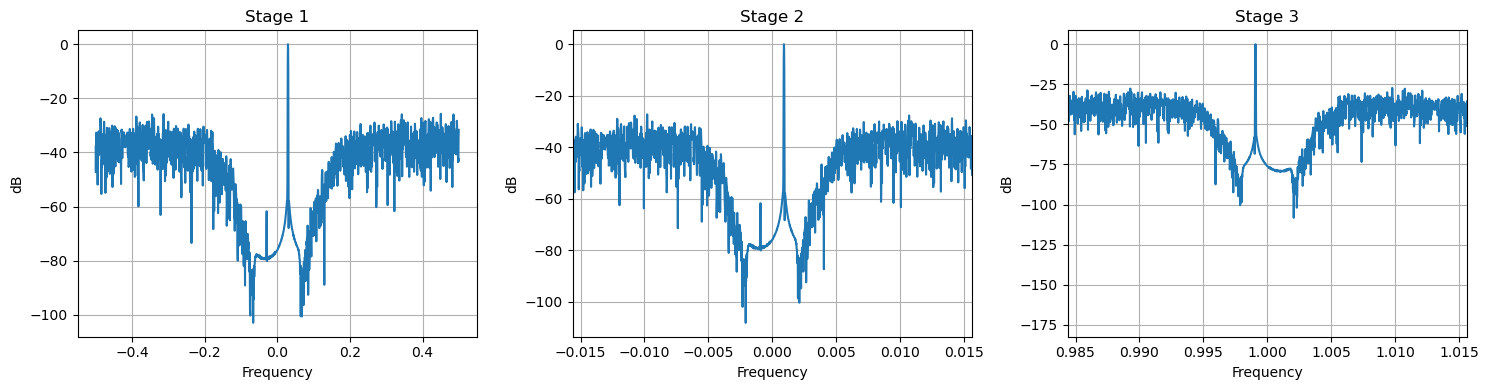

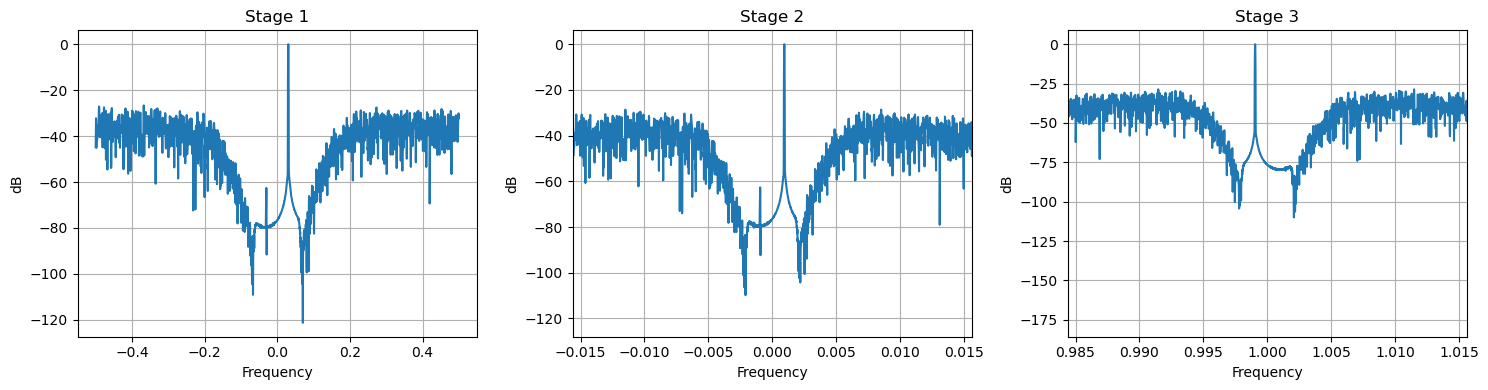

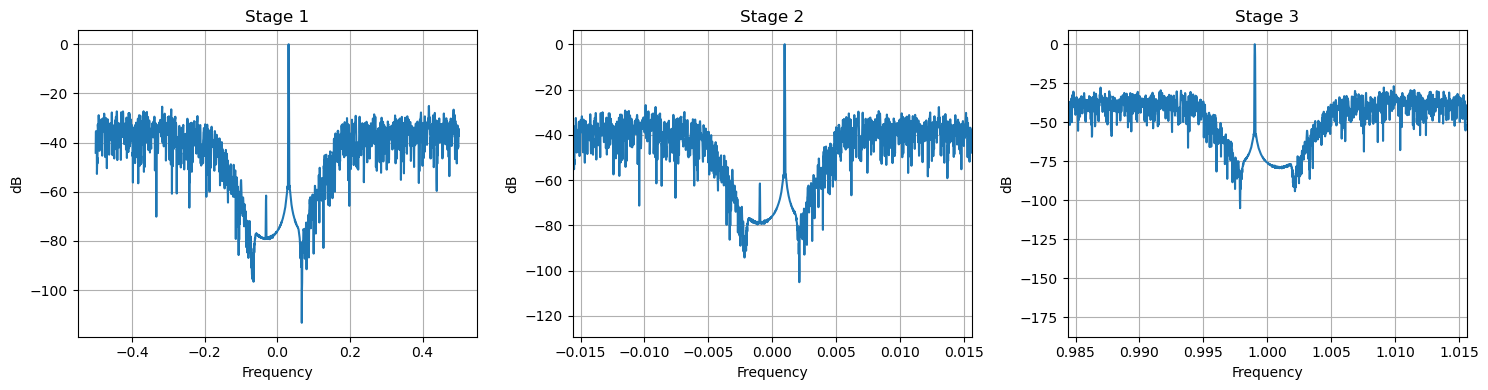

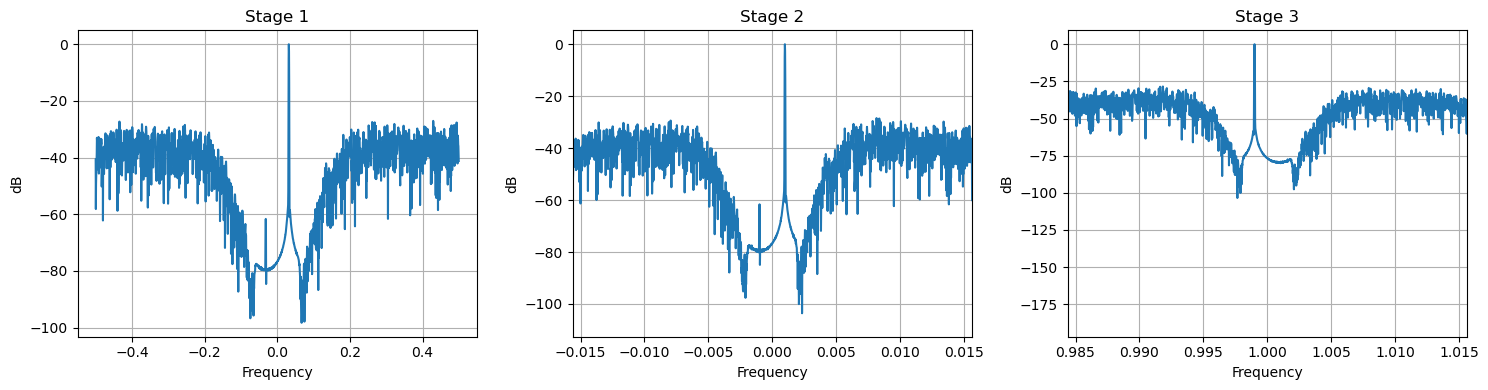

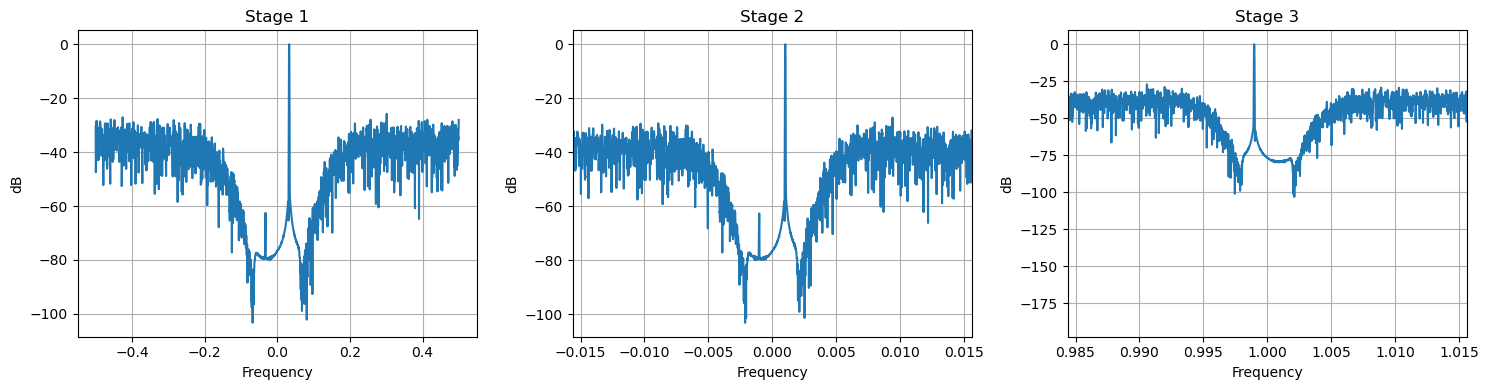

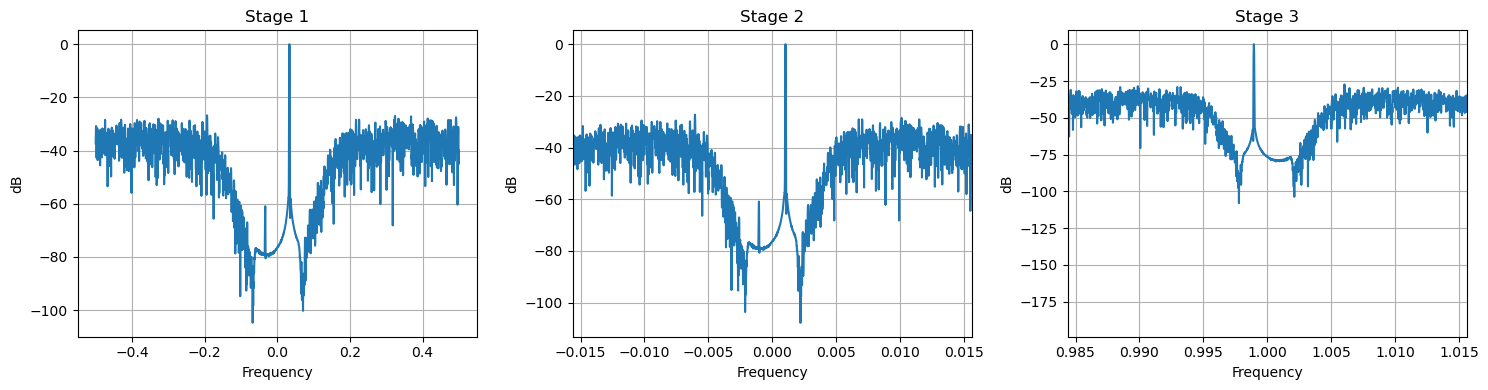

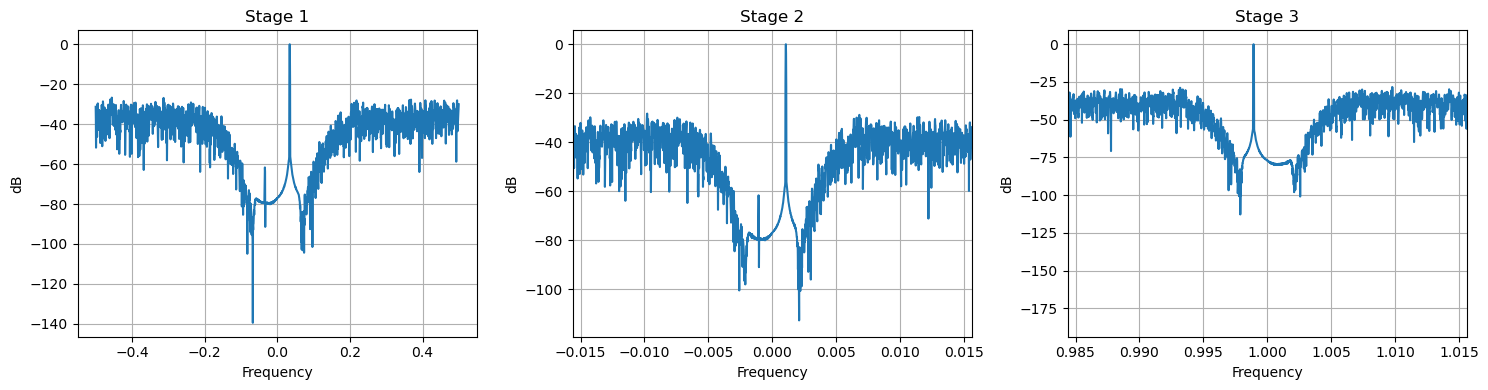

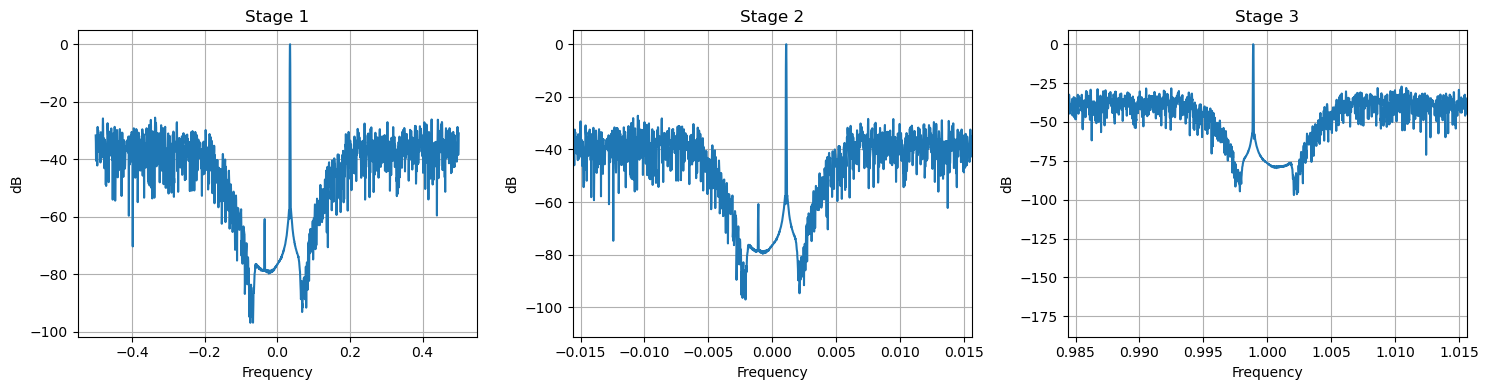

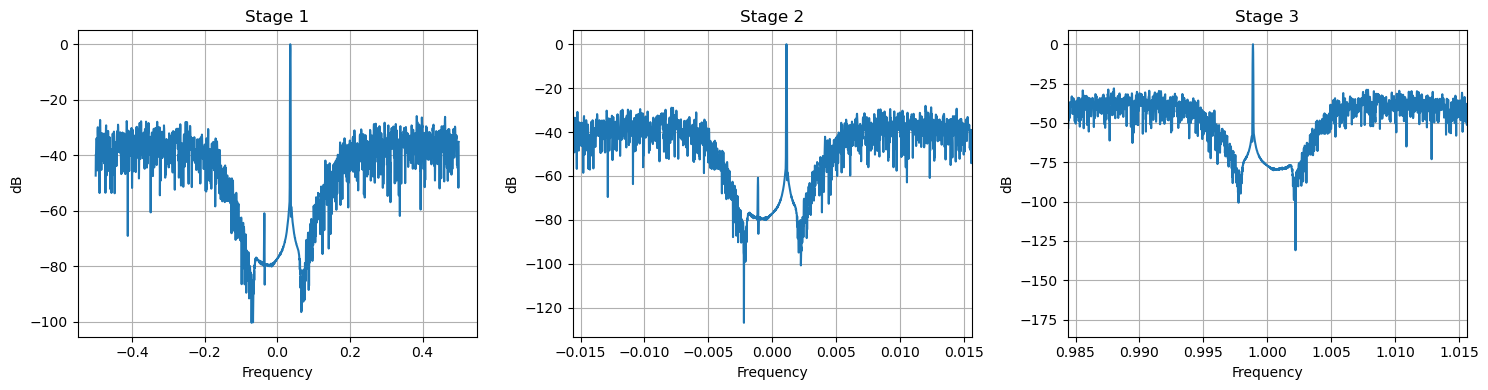

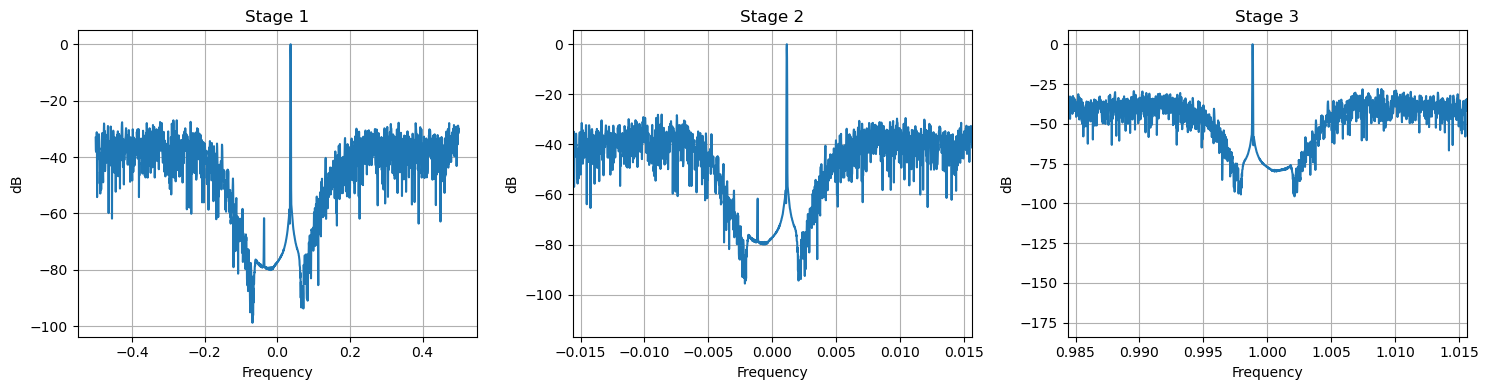

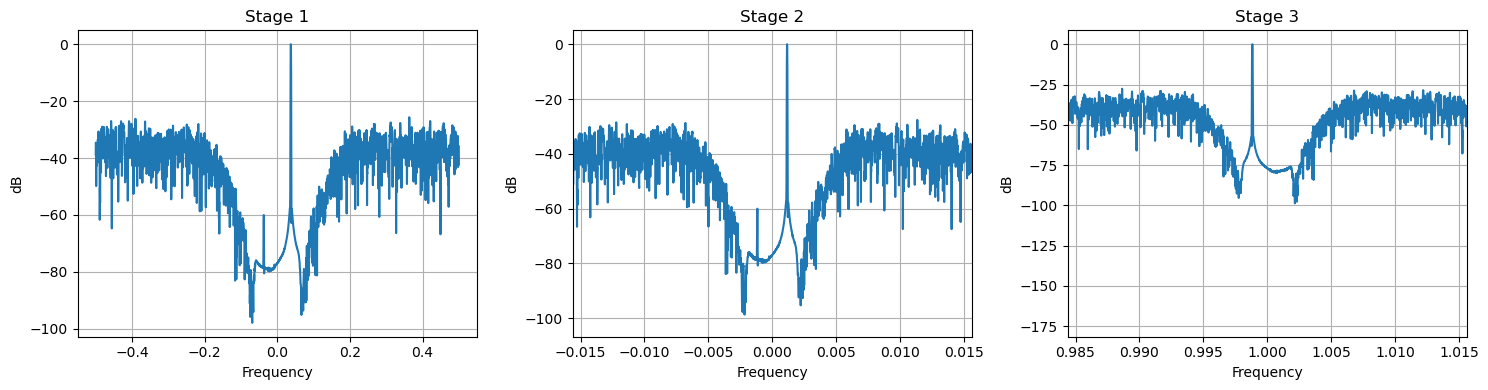

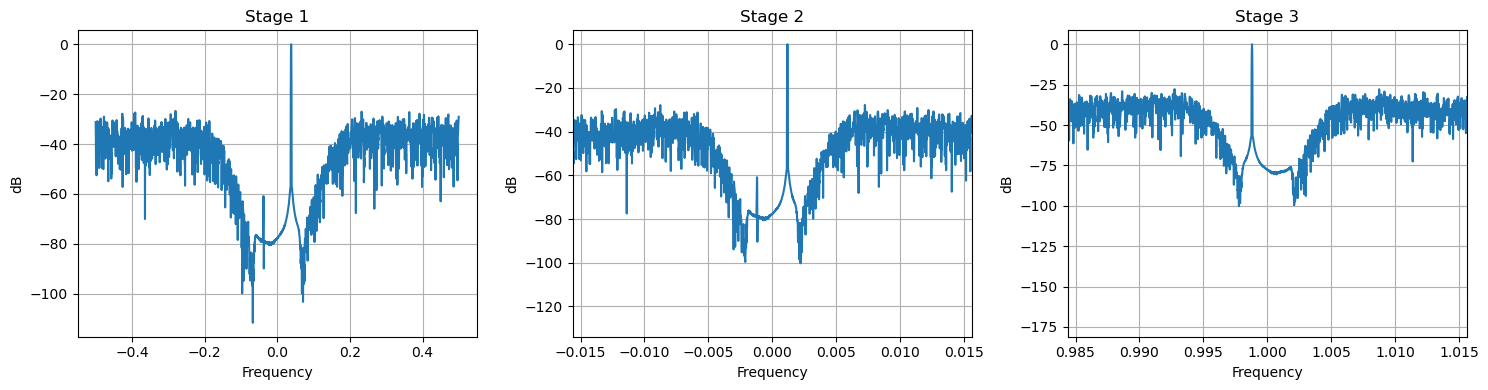

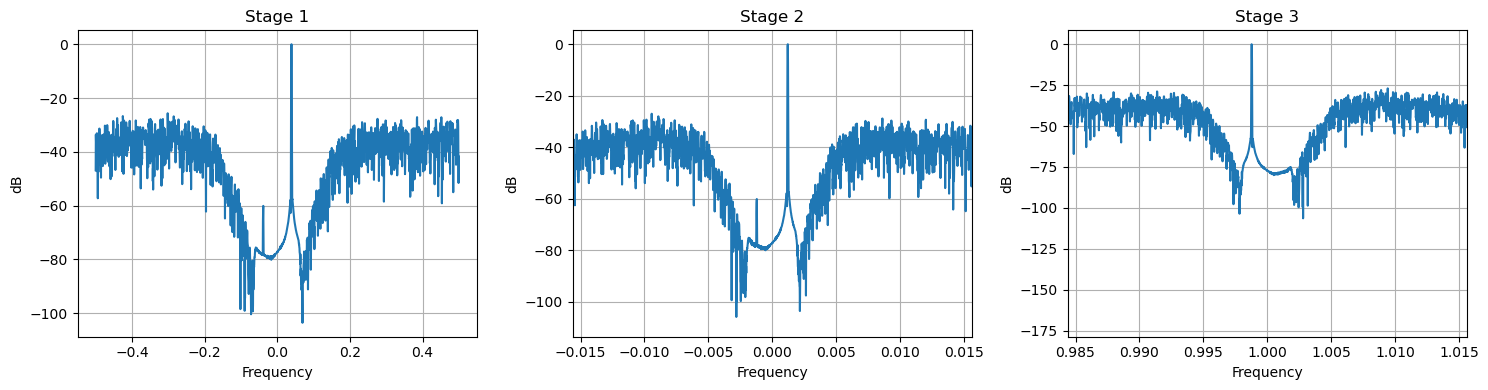

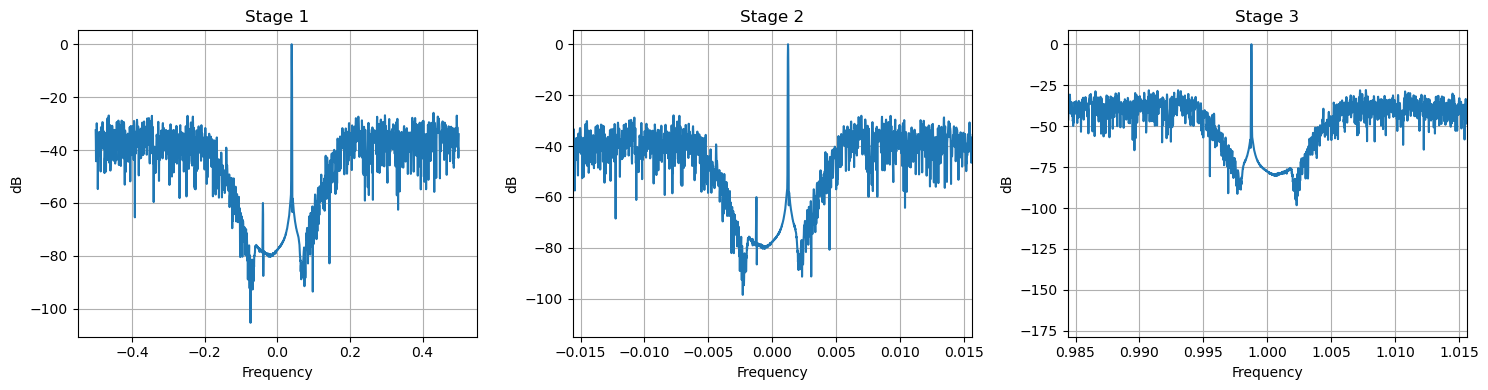

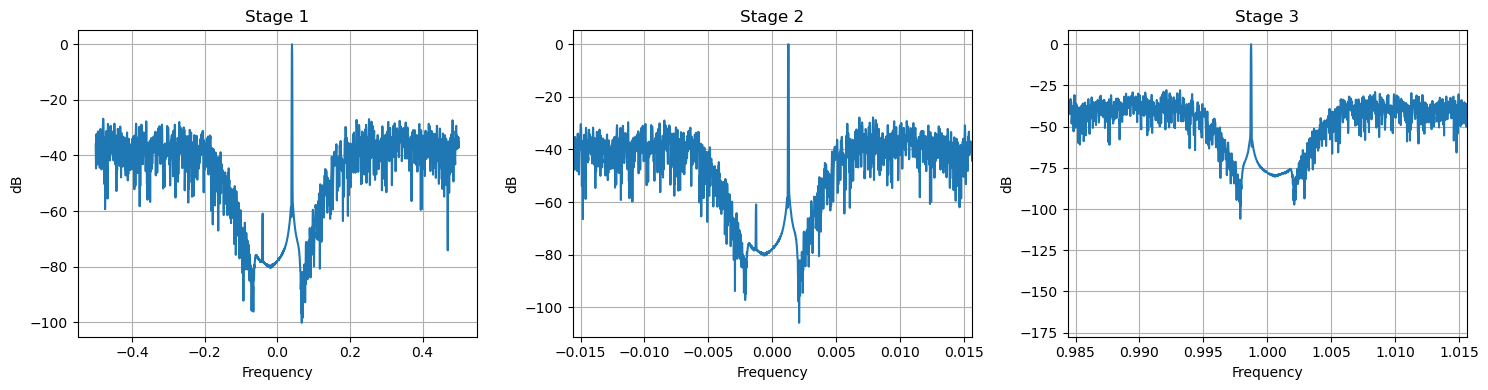

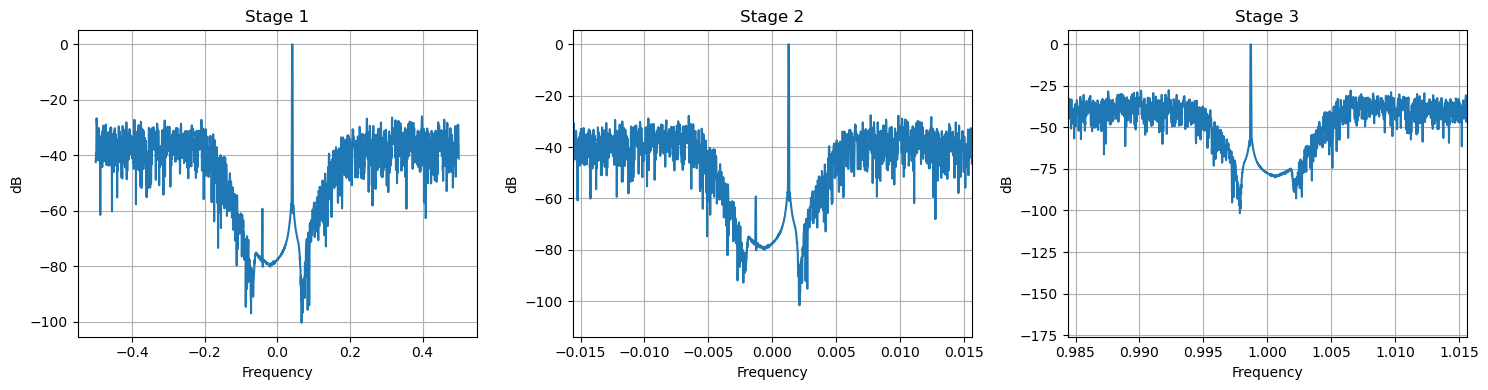

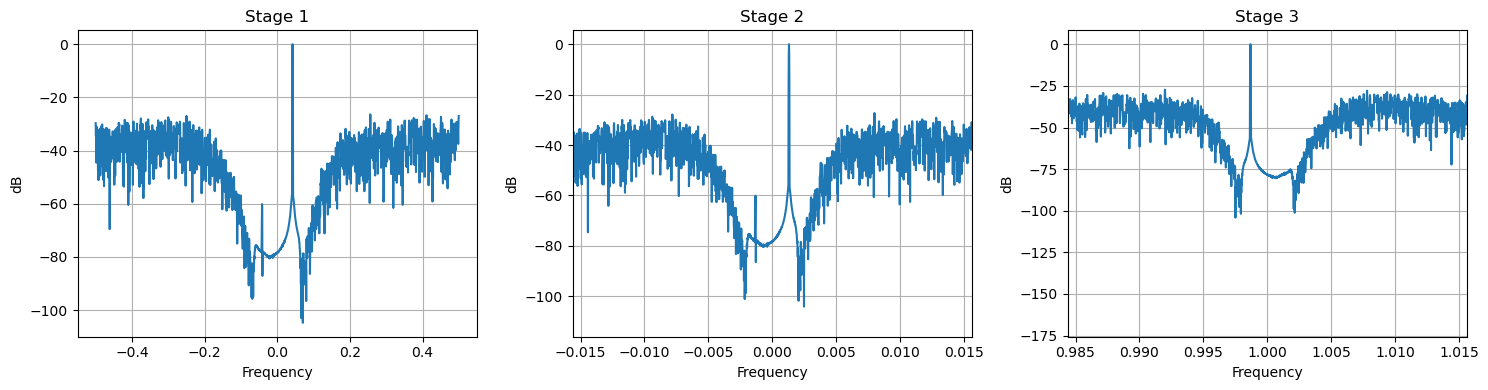

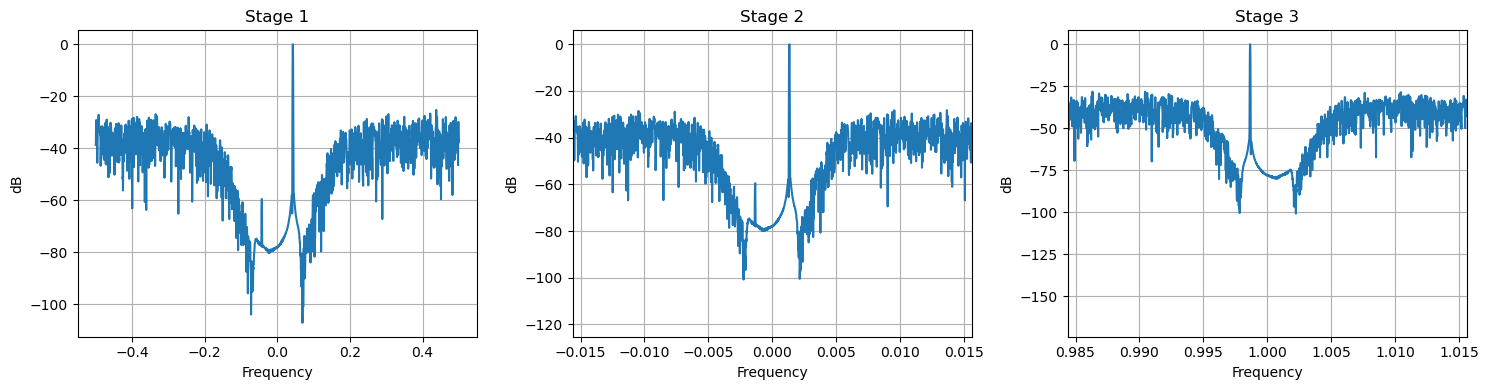

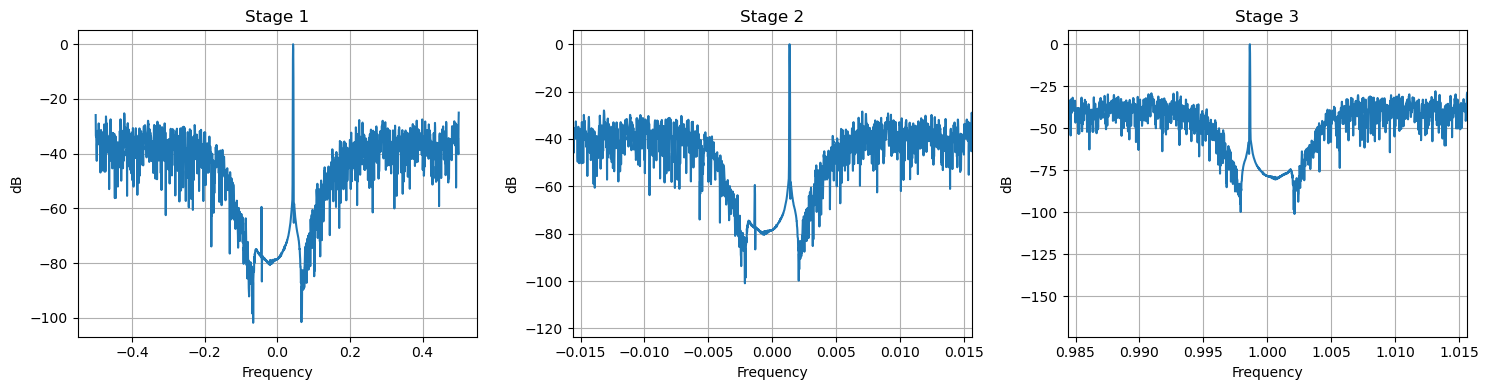

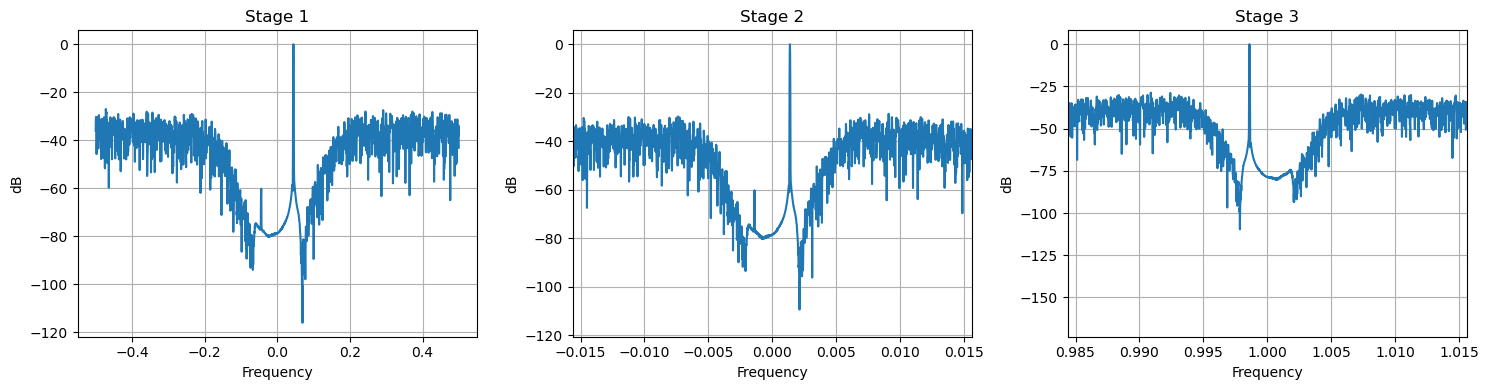

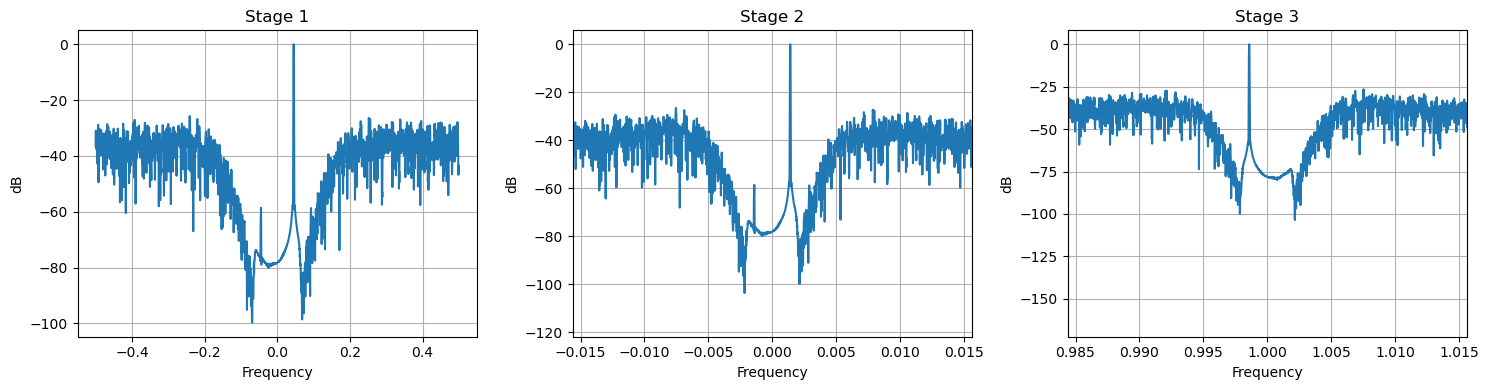

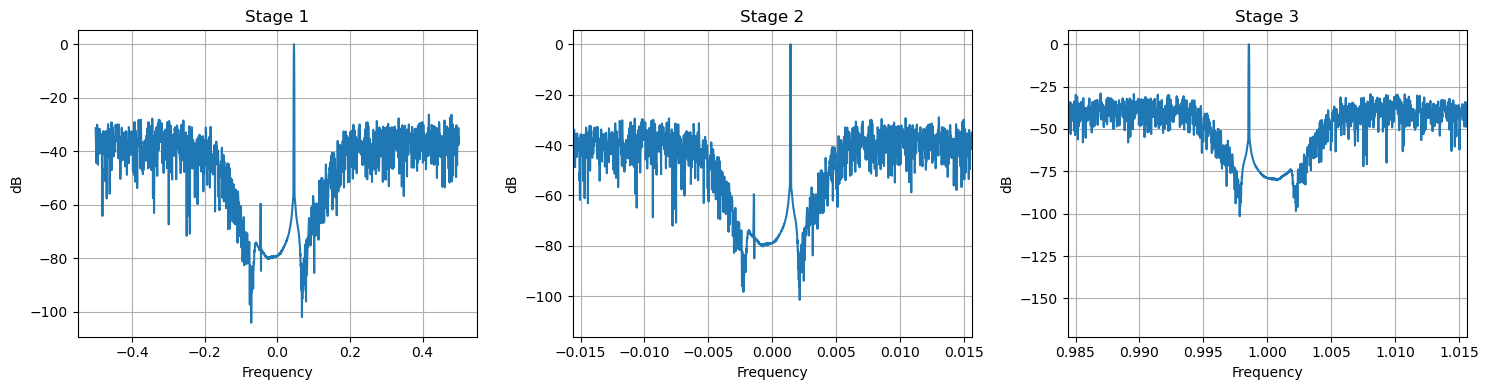

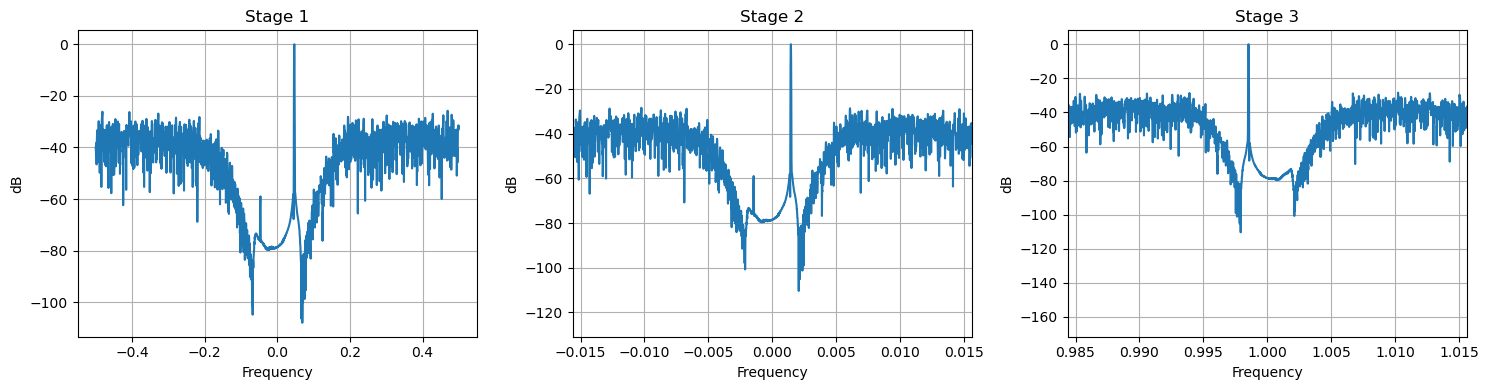

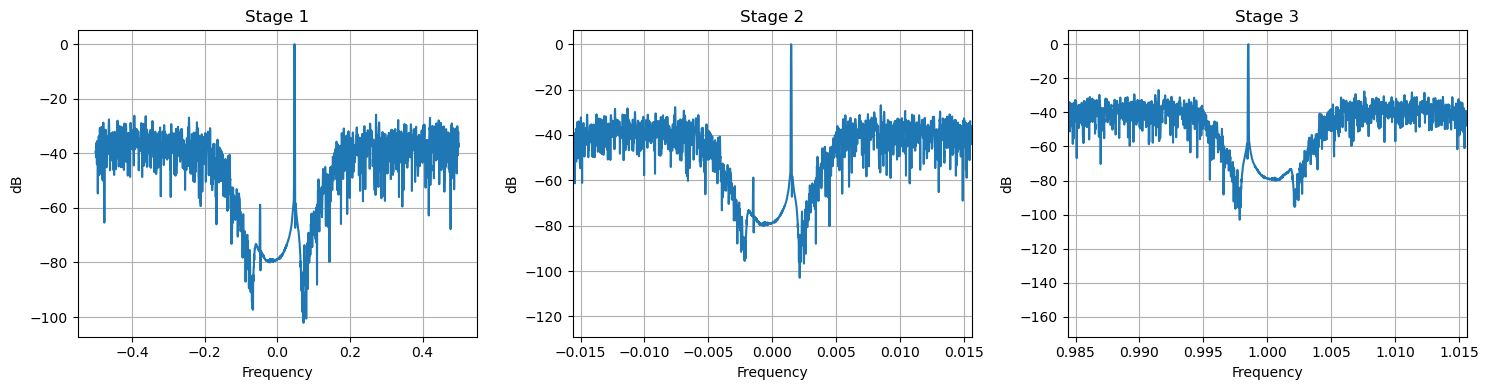

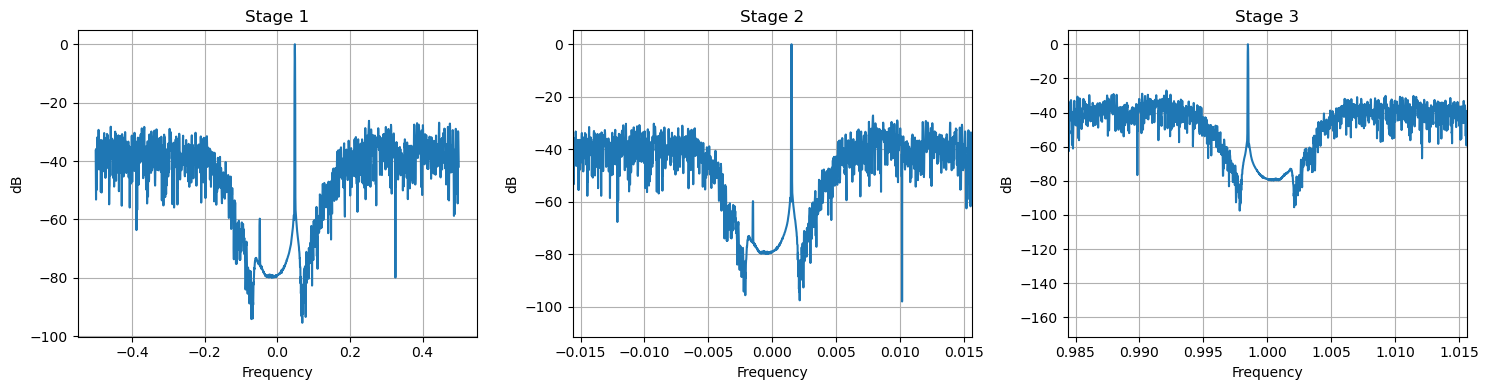

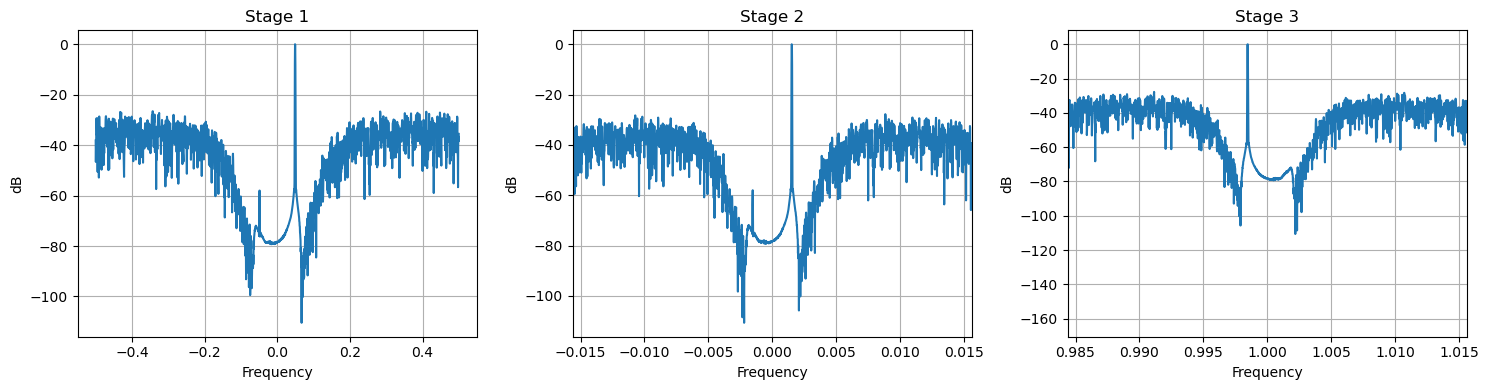

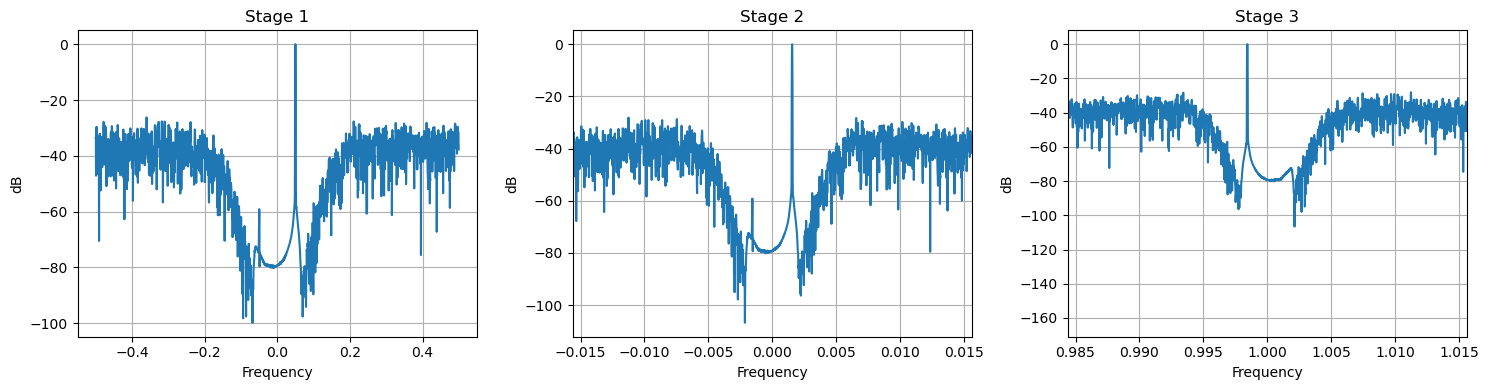

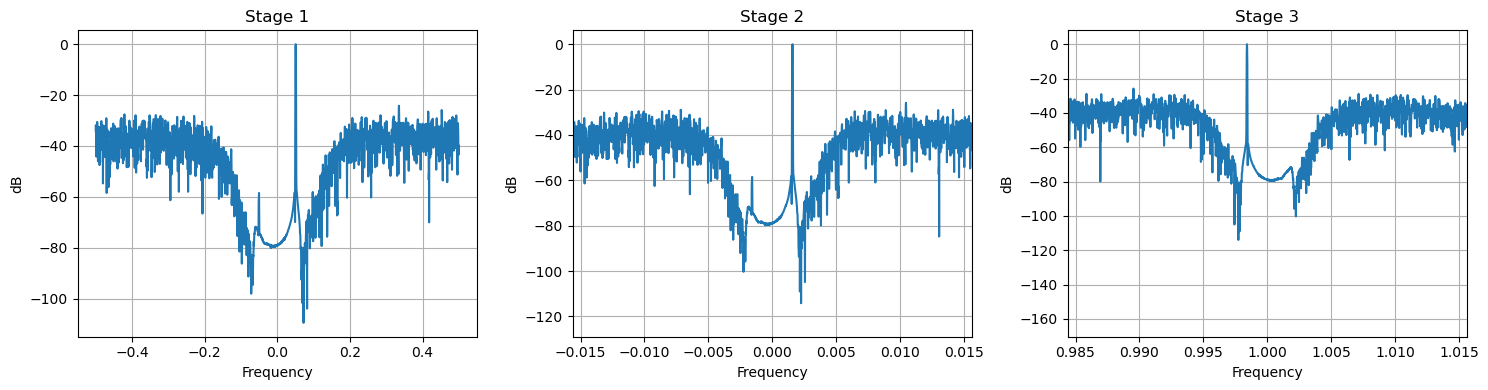

In [29]:
from pathlib import Path
import numpy as np

OUTDIR = Path(r"../data/output/")

def one(glob_iter, err):
    """Vrati tačno jedan fajl ili baci jasan exception."""
    try:
        return next(glob_iter)
    except StopIteration:
        raise FileNotFoundError(err)

def collect_files(stage: int, idx: int):
    idx_str = f"{idx:03d}"
    stage_dir = OUTDIR / f"stage{stage}"

    if stage in (1, 2):
        fi = one(stage_dir.glob(f"xout_i_stage{stage}_{idx_str}_*.txt"),
                 f"Nije nađen i-fajl za stage{stage}, idx={idx_str}")
        fq = one(stage_dir.glob(f"xout_q_stage{stage}_{idx_str}_*.txt"),
                 f"Nije nađen q-fajl za stage{stage}, idx={idx_str}")
        return fi, fq
    elif stage == 3:
        f = one(stage_dir.glob(f"xout_stage3_{idx_str}_*.txt"),
                f"Nije nađen fajl za stage3, idx={idx_str}")
        return f
    else:
        raise ValueError("Stage mora biti 1, 2 ili 3.")

def load_vec(path: Path, dtype=float):
    """Učitaj 1D vektor iz .txt (whitespace delimiter)."""
    arr = np.loadtxt(path, dtype=dtype, ndmin=1)  # ndmin=1 garantuje 1D
    return arr

def bin01_to_pm1(x):
    """Mapiraj {0,1} -> {-1,+1} bez kopiranja nepotrebno."""
    # Ako x nije celobrojan, prvo ga zaokruži ili cast-uj po potrebi.
    xi = x.astype(np.int8, copy=False)
    return np.where(xi == 0, -1, 1).astype(np.int8, copy=False)

# Glavna petlja
for idx in range(64):
    # stage 1: učitaj i i q (pretpostavka: višebitni/float/int, NE mapira se 0/1)
    s1_i_path, s1_q_path = collect_files(1, idx)
    s1_i = load_vec(s1_i_path)
    s1_q = load_vec(s1_q_path)
    s1 = s1_i + 1j * s1_q

    # stage 2: učitaj i q, pa mapiraj 0->-1, 1->+1
    s2_i_path, s2_q_path = collect_files(2, idx)
    s2_i_raw = load_vec(s2_i_path, dtype=int)
    s2_q_raw = load_vec(s2_q_path, dtype=int)
    s2_i = bin01_to_pm1(s2_i_raw)
    s2_q = bin01_to_pm1(s2_q_raw)
    s2 = s2_i + 1j * s2_q

    # stage 3: učitaj jedan fajl (realni ili 1-bit real, po opisu)
    s3_path = collect_files(3, idx)
    s3_raw = load_vec(s3_path, dtype=int)
    s3 = bin01_to_pm1(s3_raw)  # ako je 0/1; ako NIJE, ukloni ovu liniju

    s1_freq, s1_fftdB, an = fftdB(s1, True)
    s2_freq, s2_fftdB, an = fftdB(s2, True)
    s3_freq, s3_fftdB, an = fftdB(s3, True)
    s3_freq *= 4

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 red, 3 kolone
    # Stage 1
    axes[0].plot(s1_freq, s1_fftdB)
    axes[0].set_title("Stage 1")
    axes[0].set_xlabel("Frequency")
    axes[0].set_ylabel("dB")
    axes[0].grid(True)
    # Stage 2
    axes[1].plot(s2_freq, s2_fftdB)
    axes[1].set_xlim([-0.5/32, 0.5/32])
    axes[1].set_title("Stage 2")
    axes[1].set_xlabel("Frequency")
    axes[1].set_ylabel("dB")
    axes[1].grid(True)
    # Stage 3
    axes[2].plot(s3_freq, s3_fftdB)
    axes[2].set_xlim([1-0.5/32, 1+0.5/32])
    axes[2].set_title("Stage 3")
    axes[2].set_xlabel("Frequency")
    axes[2].set_ylabel("dB")
    axes[2].grid(True)
    plt.tight_layout()
    plt.show()


